# Modelling

code for our models they include an SVM, K nearst neighbour and XGBoost models as well as their ensemble. THE SVM is our baseline, specifically all data with the original level and no level balancing is our baseline model

# Installing Packages

In [18]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install matplot
!{sys.executable} -m pip install seaborn

# Preprocessing of Data

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer

import copy

# Helper function: simply reads a csv file and return it as a dataframe
def read_data(data_file):
  data_df = pd.read_csv(data_file)
  return data_df

def drop_features(data_df, features_to_drop):
  return data_df.drop(columns=features_to_drop, inplace=True)

def segregate_noisy_data(data_df):
  copied_data = copy.deepcopy(data_df)
  non_noisy_df = copied_data.loc[(copied_data['noisy_train'] == 0)]
  noisy_df = copied_data.loc[(copied_data['noisy_train'] == 1)]
  return non_noisy_df, noisy_df

def remove_noisy_data(data_df):
  print(f'''Rows dropped because of low duration: 
        {len(data_df[data_df['noisy'] == 1])}\n''')
  
  return data_df.drop(data_df[data_df['noisy'] == 1].index, inplace=True)

# Helper function: cleans data based on xyz
def preprocessing_data(data_df):

  # Clean data based on duration value
  print(f'''Rows dropped because of low duration: \
        {len(data_df[data_df['duration'] < 2])}\n''')
  
  data_df.drop(data_df[data_df['duration'] < 2].index, inplace=True)

  # Extract filenames
  filenames = data_df['file_name'].values.tolist()

  return (data_df, filenames)


Read Data

In [3]:
# Fetch .csv file and store it as a dataframe
aggression_data_df = read_data('../extracted/full-train-features.csv')

Extract data, filenames and labels after preprocessing data

In [4]:
print(f'Shape of the data before cleaning it: {aggression_data_df.shape}\n')
print(aggression_data_df.tail())

aggression_data_df, filenames = preprocessing_data(aggression_data_df)

print(f'Shape of the data after cleaning it: {aggression_data_df.shape} \n')

Shape of the data before cleaning it: (2146, 23)

                      file_name  duration  analyse_harmonics  \
2141  xdz15thrnem51_processed_5      10.0           5.465491   
2142  xdz15thrnem51_processed_6      10.0           6.879443   
2143  xdz15thrnem51_processed_7      10.0           4.468770   
2144  xdz15thrnem51_processed_8      10.0           8.581945   
2145  xdz15thrnem51_processed_9      10.0           2.829222   

      get_number_sylls  get_number_words  pauses  get_max_intensity  \
2141               1.3               1.0     0.1         104.113896   
2142               0.2               0.3     0.1         108.028173   
2143               1.8               1.1     0.1         104.678268   
2144               0.3               0.1     0.1         109.335715   
2145               0.6               0.6     0.1         105.455598   

      analyse_intensity  analyse_pitch  analyse_pitch_range  ...  \
2141          69.550541     199.893943           443.057705  ...   
21

Segregate data based on noisy vs not noisy

In [5]:
non_noisy_df, noisy_df = segregate_noisy_data(aggression_data_df)

print(f"Shape of noisy data: {noisy_df.shape} \n")
print(f"Shape of non noisy data: {non_noisy_df.shape}\n")

Shape of noisy data: (262, 23) 

Shape of non noisy data: (1849, 23)



**NOTE: Modelling of this project is split into 3 groups. Therefore, all the steps in this notebook below are repeated once for each group**
1. Noisy and Non Noisy Data
2. Noisy Data
3. Non Noisy Data

Drop features

In [6]:
features_to_drop = ['file_name', 'duration','get_number_sylls',
                    'get_number_words', 'pauses',
                    'number_of_segments_train', 'number_of_voices_parent_train',
                    'extra_sounds_train', 'Notes_train']

# remove features for Group 1
print(f'Shape of the data for Group 1 before dropping features: {aggression_data_df.shape} \n')
drop_features(aggression_data_df, features_to_drop)

# remove features for Group 2
print(f'Shape of the data for Group 2 before dropping features: {non_noisy_df.shape} \n')
drop_features(non_noisy_df, features_to_drop)

# remove features for Group 3
print(f'Shape of the data for Group 3 before dropping features: {noisy_df.shape} \n')
drop_features(noisy_df, features_to_drop)


print(f'Shape of the data for Group 1 after dropping features: {aggression_data_df.shape} \n')
print(f'Shape of the data for Group 2 after dropping features: {non_noisy_df.shape} \n')
print(f'Shape of the data for Group 3 after dropping features: {noisy_df.shape} \n')

Shape of the data for Group 1 before dropping features: (2111, 23) 

Shape of the data for Group 2 before dropping features: (1849, 23) 

Shape of the data for Group 3 before dropping features: (262, 23) 

Shape of the data for Group 1 after dropping features: (2111, 14) 

Shape of the data for Group 2 after dropping features: (1849, 14) 

Shape of the data for Group 3 after dropping features: (262, 14) 



### Examine dataframe from each group

In [7]:
print(aggression_data_df.info())
print(non_noisy_df.info())
print(noisy_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2145
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   analyse_harmonics      2111 non-null   float64
 1   get_max_intensity      2111 non-null   float64
 2   analyse_intensity      2111 non-null   float64
 3   analyse_pitch          2110 non-null   float64
 4   analyse_pitch_range    2110 non-null   float64
 5   analyse_shimmer        2110 non-null   float64
 6   analyse_jitter         2110 non-null   float64
 7   spectral_slope         2111 non-null   float64
 8   mean_spectral_rolloff  2111 non-null   float64
 9   get_energy             2111 non-null   float64
 10  parent_file_train      2111 non-null   object 
 11  parent_label_train     2111 non-null   int64  
 12  segment_label_train    2111 non-null   int64  
 13  noisy_train            2111 non-null   int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 247.4+

Remove rows that have `NaN` as one of the feature values

1 row in both group 1 and group 2 have `NaN`

In [8]:
aggression_data_df.dropna(inplace=True)
non_noisy_df.dropna(inplace=True)
noisy_df.dropna(inplace=True)


Convert values in 'get_max_intensity' from string to float 

In [9]:
aggression_data_df['get_max_intensity'] = pd.to_numeric(aggression_data_df['get_max_intensity'])
non_noisy_df['get_max_intensity'] = pd.to_numeric(non_noisy_df['get_max_intensity'])
noisy_df['get_max_intensity'] = pd.to_numeric(noisy_df['get_max_intensity'])

noisy_df.head(15)

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
5,3.859515,99.656235,66.680578,394.698825,461.355272,0.181399,0.038183,-0.011376,1164.256959,0.018612,01avx2fm1t961,3,2,1
6,4.301706,100.620469,67.893825,355.316875,439.101386,0.199342,0.043200,-0.014285,1043.864847,0.025372,01avx2fm1t961,3,2,1
7,4.134565,101.666306,68.782272,381.025067,513.486703,0.192137,0.038323,-0.017456,1025.571987,0.028210,01avx2fm1t961,3,2,1
64,4.832865,108.258940,77.036272,219.231909,499.293824,0.173476,0.024539,-0.089942,1778.052375,0.139028,09etqbnf0uc61,0,0,1
88,3.707670,107.282961,77.338457,107.077688,523.583154,0.161535,0.027049,-0.157909,903.503189,0.216111,0cho11mt05y51,0,0,1


Segregate data df and label df and reset indexes from all groups

In [10]:
feature_labels = ['parent_label_train', 'segment_label_train', 'noisy_train']

label_df = aggression_data_df.filter(items=feature_labels)
aggression_df = aggression_data_df#.drop(columns=feature_labels)

label_non_noisy_df = non_noisy_df.filter(items=feature_labels)
aggression_non_noisy_df = non_noisy_df#.drop(columns=feature_labels)

label_noisy_df = noisy_df.filter(items=feature_labels)
aggression_noisy_df = noisy_df#.drop(columns=feature_labels)

label_df.reset_index(drop=True, inplace=True)
aggression_df.reset_index(drop=True, inplace=True)

label_non_noisy_df.reset_index(drop=True, inplace=True)
aggression_non_noisy_df.reset_index(drop=True, inplace=True)

label_noisy_df.reset_index(drop=True, inplace=True)
aggression_noisy_df.reset_index(drop=True, inplace=True)

print(f"Shape of labelled data in Group 1:{label_df.shape} \n Shape of data in Group 1: {aggression_df.shape}\n")
print(f"Shape of labelled data in Group 2:{label_non_noisy_df.shape} \n Shape of data in Group 2: {aggression_non_noisy_df.shape}\n")
print(f"Shape of labelled data in Group 3:{label_noisy_df.shape} \n Shape of data in Group 3: {aggression_noisy_df.shape}\n")

Shape of labelled data in Group 1:(2110, 3) 
 Shape of data in Group 1: (2110, 14)

Shape of labelled data in Group 2:(1848, 3) 
 Shape of data in Group 2: (1848, 14)

Shape of labelled data in Group 3:(262, 3) 
 Shape of data in Group 3: (262, 14)



Extra code to run model against parent labels and not segment labels

In [11]:
aggression_df #label_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,5.465491,104.113896,69.550541,199.893943,443.057705,0.196757,0.033226,-0.020890,1002.676098,0.036482,xdz15thrnem51,2,1,0
2106,6.879443,108.028173,75.501002,258.536830,379.915372,0.149580,0.024206,-0.081411,1023.670363,0.141290,xdz15thrnem51,2,2,0
2107,4.468770,104.678268,71.100226,194.904220,493.340814,0.162628,0.034465,-0.028155,980.207236,0.051732,xdz15thrnem51,2,1,0
2108,8.581945,109.335715,76.784989,285.988051,520.259229,0.149758,0.022509,-0.108299,1146.211888,0.190454,xdz15thrnem51,2,2,0


In [12]:
# print(aggression_noisy_df.tail(10))

to_add = aggression_noisy_df.parent_file_train.unique()

actual_noisy_test_df = pd.DataFrame(to_add, columns = ['filename'])
actual_noisy_test_df["parent_label"] = -1

actual_noisy_test_df.head()

for fn in to_add:    
    actual_noisy_test_df.loc[actual_noisy_test_df['filename'] == fn, ['parent_label']] = noisy_df.loc[noisy_df.parent_file_train == fn, 'parent_label_train'].values[0]
    # actual_noisy_test_df.at[0, fn] = aggression_noisy_df.iloc[0][fn]

actual_noisy_test_df
# print(noisy_df.loc[noisy_df.parent_file_train == '3nvn1lwacgg61', 'parent_label_train'].values[0])

,filename,parent_label
0,00g8dfgpqpt61,0
1,00g8dfgpqpt62,0
2,00g8dfgpqpt63,0
3,01avx2fm1t961,3
4,09etqbnf0uc61,0
...,...,...
69,wjha1sf516b71,0
70,wkgibcp6fro51,0
71,wocoyi48sgs51,2
72,xbw64yf04th51,1


# Standardization

In [13]:
from sklearn.preprocessing import StandardScaler

# Helper function: returns a standardized dataframe
def standardize(df):
    org_features = df.columns
    features = [i for i in df.columns if i not in ['parent_file_train'] + feature_labels]
    
    values_array = df.loc[:, features].values

    # Print data before standardization to compare
    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")
    print(f"Tail of the data pre standardization: \n{values_array[-5:]} \n\n")

    # Invoke standardization
    # Numeric columns: Std scaler
    pipeline = ColumnTransformer([
        ('transform_numeric',StandardScaler(),features),    
    ], remainder='passthrough')


    # Transform input vector (features)
    df =  pd.DataFrame(pipeline.fit_transform(df),columns=org_features)
    
    #values_array = StandardScaler().fit_transform(values_array)
    
    values_array = df.loc[:, features].values  # To do the below computation
    # Print data after standardization to compare
    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")
    print(f"Tail of the data post standardization: \n{values_array[-5:]}")

    return df

Standardize data for all groups

In [14]:
standardized_aggression_df = standardize(aggression_df)
standardized_non_noisy_df = standardize(aggression_non_noisy_df)
standardized_noisy_df = standardize(aggression_noisy_df)

Before Standardization 

Mean and Standard Deviation
Mean = 207.03214462485482 ; Standard Deviation = 405.89809500083527
Shape to verify: (2110, 10) 

Tail of the data pre standardization: 
[[ 5.46549109e+00  1.04113896e+02  6.95505405e+01  1.99893943e+02
   4.43057705e+02  1.96756913e-01  3.32257430e-02 -2.08904800e-02
   1.00267610e+03  3.64816420e-02]
 [ 6.87944281e+00  1.08028173e+02  7.55010015e+01  2.58536830e+02
   3.79915372e+02  1.49580347e-01  2.42058080e-02 -8.14106130e-02
   1.02367036e+03  1.41290270e-01]
 [ 4.46876994e+00  1.04678268e+02  7.11002256e+01  1.94904220e+02
   4.93340814e+02  1.62627554e-01  3.44649850e-02 -2.81549870e-02
   9.80207236e+02  5.17316800e-02]
 [ 8.58194493e+00  1.09335715e+02  7.67849889e+01  2.85988051e+02
   5.20259229e+02  1.49757852e-01  2.25093080e-02 -1.08298994e-01
   1.14621189e+03  1.90454480e-01]
 [ 2.82922212e+00  1.05455598e+02  7.46545323e+01  1.86190085e+02
   4.86287854e+02  1.95173250e-01  3.43624990e-02 -8.18768770e-02
   6.98359

In [15]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


# Modelling

In [16]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import svm, mixture
from sklearn.model_selection import GridSearchCV, train_test_split

def hyperparameter_tuning(ml_model, data, label, parameters):
    clf = GridSearchCV(ml_model, parameters, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

def run_model(ml_model, data, label, label_name):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = data.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    print('Feature set:',feature_set)
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
    
    
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data
    #X_test['segment_actual'] = y_test  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

def confusion_matrix_graph(model_name, actual_labels, predicted_labels, label_names):
    matrix = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap="Greens")
    ax.set_title(model_name);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    print("\n\n Aggregate report \n", classification_report(actual_labels, predicted_labels, target_names=label_names))

    plt.show()    



Convert dataframes to numpy array

In [17]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


In [18]:
data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_np = label_df['segment_label_train'].to_numpy()

data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_non_noisy_np = label_non_noisy_df['segment_label_train'].to_numpy()

data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_noisy_np = label_noisy_df['segment_label_train'].to_numpy()

C:\Users\Paige\AppData\Local\Temp\ipykernel_12388\2163191907.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_12388\2163191907.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_12388\2163191907.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", 

## SVM

Hyperparameter Tuning for SVM

In [ ]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_np, label_np, quick_parameters)
hyperparameter_tuning(svc, data_non_noisy_np, label_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_noisy_np, label_noisy_np, quick_parameters)

Results from hyper parameter tuning for SVM using `original_parameters`: **`{'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}`**

***NOTE: `orginal_parameters` were the actual parameters against which the parameters were tuned. However, the results took over 4 hours to be processed. Therefore, `quick_parameters` is just a smaller subset of the `original_parameters`.***

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Run SVM model

## Group 1 (All data) is our baseline for segments

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5416363138646112; Accuracy score = 0.5568181818181818 ; Precisison Score = 0.5512002751777957; Recall score = 0.5568181818181818


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.78      0.71       235
           1       0.50      0.48      0.49       145
           2       0.29      0.27      0.28        85
           3       0.65      0.27      0.38        63

    accuracy                           0.56       528
   macro avg       0.52      0.45      0.47       528
weighted avg       0.55      0.56      0.54       528



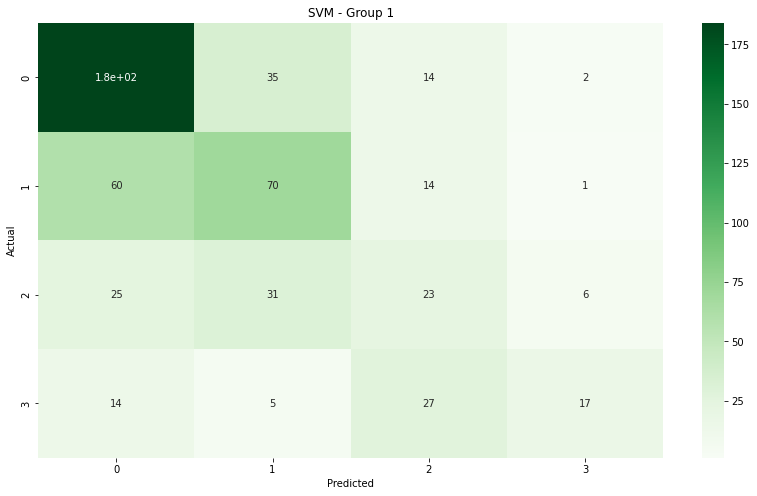

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5669503012142729; Accuracy score = 0.5714285714285714 ; Precisison Score = 0.5965329014541454; Recall score = 0.5714285714285714


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.72      0.67       177
           1       0.52      0.53      0.52       157
           2       0.47      0.46      0.47        82
           3       1.00      0.35      0.52        46

    accuracy                           0.57       462
   macro avg       0.65      0.51      0.54       462
weighted avg       0.60      0.57      0.57       462



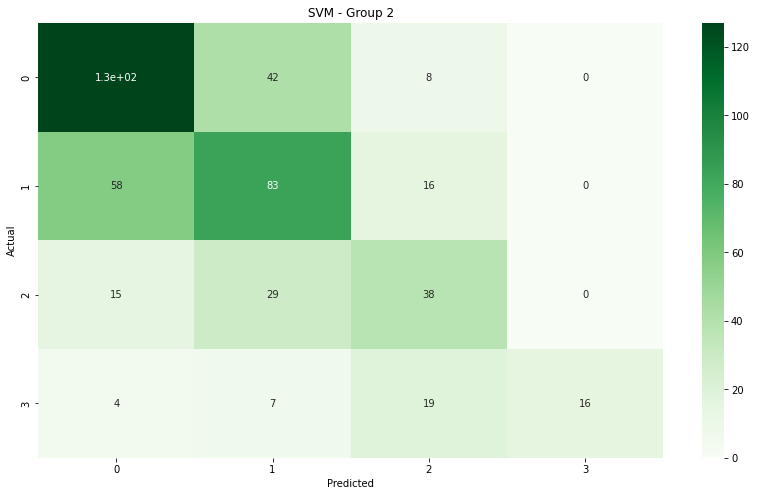

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6493166963755197; Accuracy score = 0.7121212121212122 ; Precisison Score = 0.5978685478059695; Recall score = 0.7121212121212122


 Aggregate report 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85        38
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         7
           3       0.65      0.69      0.67        16

    accuracy                           0.71        66
   macro avg       0.35      0.41      0.38        66
weighted avg       0.60      0.71      0.65        66



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

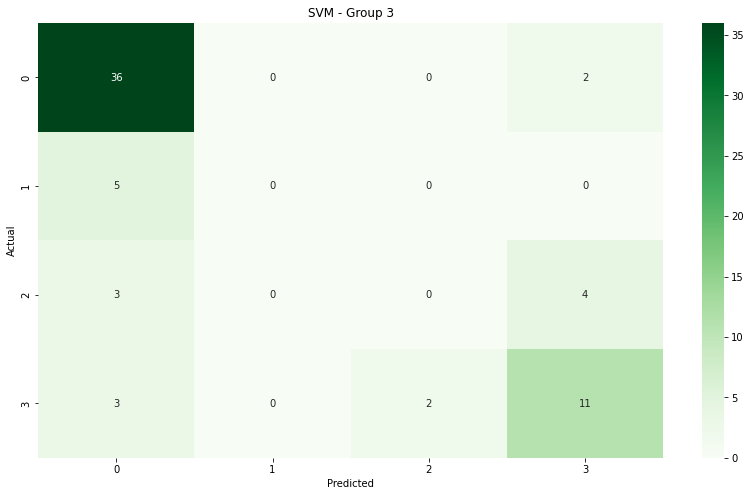

In [121]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df, standardized_non_noisy_df, standardized_noisy_df]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']
c = [1, 10, 1]

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])

#### Parent label analysis

## Group 1 (All data) is our baseline for Parent



 Aggregate report 
               precision    recall  f1-score   support

           0       0.47      0.70      0.56        69
           1       0.29      0.25      0.27        51
           2       0.19      0.20      0.19        41
           3       0.62      0.23      0.33        44

    accuracy                           0.39       205
   macro avg       0.39      0.34      0.34       205
weighted avg       0.40      0.39      0.37       205



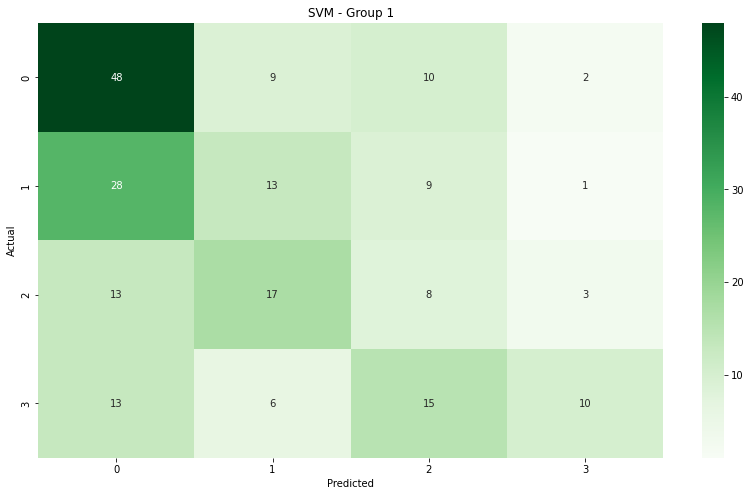



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.68      0.61        53
           1       0.33      0.40      0.36        50
           2       0.41      0.41      0.41        44
           3       1.00      0.23      0.37        31

    accuracy                           0.46       178
   macro avg       0.57      0.43      0.44       178
weighted avg       0.53      0.46      0.45       178



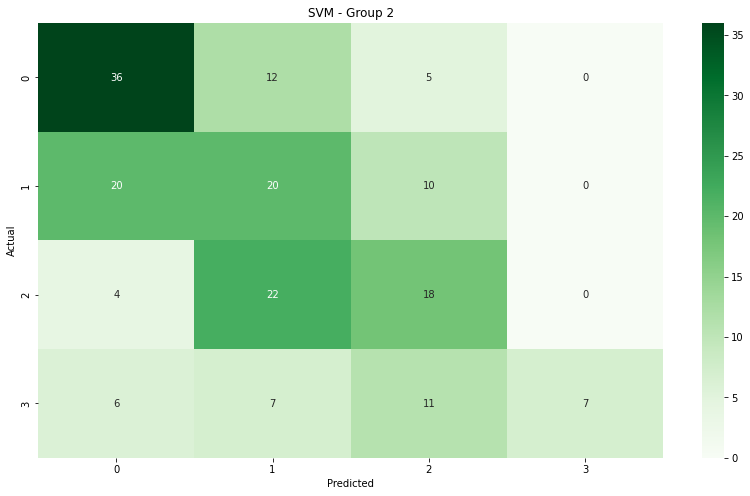



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        17
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         3
           3       0.82      0.64      0.72        14

    accuracy                           0.62        42
   macro avg       0.35      0.41      0.36        42
weighted avg       0.51      0.62      0.54        42



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

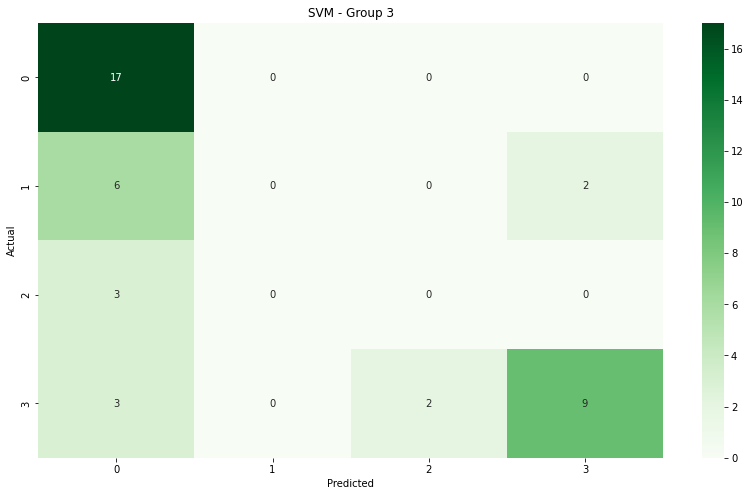

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,2
1,0202on89vhz61,0,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,2,0
4,08ss0a3zs0061,2,0
...,...,...,...
200,x705shsub7m61,1,0
201,xbw64yf04th51,1,0
202,xc76oggvh2471,1,2
203,xdz15thrnem51,2,2


In [122]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

### Test combining level 1 and level 2 as they appear to have difficulty classifying

In [21]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


combine the labels in all dataframes

In [36]:
standardized_aggression_mergedlabels_df = standardized_aggression_df.copy()
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2, 'segment_label_train' ] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 3, 'segment_label_train'] = 2
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 2, 'parent_label_train'] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 3, 'parent_label_train'] = 2
print(standardized_aggression_mergedlabels_df['segment_label_train'].unique())
print(standardized_aggression_mergedlabels_df['parent_label_train'].unique())

[0 2 1]
[0 2 1]


In [37]:
standardized_mergedlabels_non_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 0]
standardized_mergedlabels_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 1]

convert to numpy arrays

In [38]:
data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_np = standardized_aggression_mergedlabels_df['segment_label_train'].to_numpy()
label_merged_np=label_merged_np.astype('int')

data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df['segment_label_train'].to_numpy()
label_merged_non_noisy_np=label_merged_non_noisy_np.astype('int')

data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_noisy_np = standardized_mergedlabels_noisy_df['segment_label_train'].to_numpy()
label_merged_noisy_np=label_merged_noisy_np.astype('int')

/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
/var/folders/7b/v9yf5j856tggrfg1tm641t9c0000gn/T/ipykernel_23664/2370931604.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_merged_noisy_np = stand

Get new hyper params

In [182]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_merged_np, label_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_non_noisy_np, label_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_noisy_np, label_merged_noisy_np, quick_parameters)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6542990896571458; Accuracy score = 0.6571969696969697 ; Precisison Score = 0.6567046612918173; Recall score = 0.6571969696969697


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       224
           1       0.64      0.70      0.67       253
           2       0.62      0.41      0.49        51

    accuracy                           0.66       528
   macro avg       0.65      0.59      0.61       528
weighted avg       0.66      0.66      0.65       528



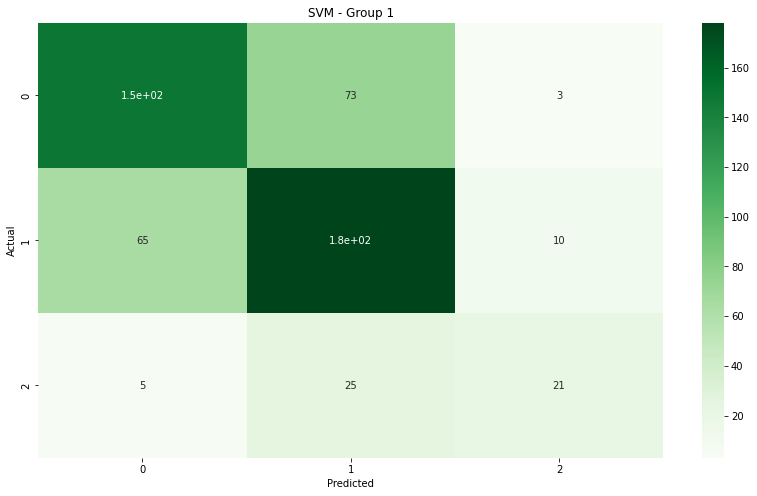

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6550345443361341; Accuracy score = 0.6623376623376623 ; Precisison Score = 0.6809816371845502; Recall score = 0.6623376623376623


 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.62      0.66       205
           1       0.63      0.76      0.69       222
           2       0.91      0.29      0.43        35

    accuracy                           0.66       462
   macro avg       0.75      0.56      0.59       462
weighted avg       0.68      0.66      0.66       462



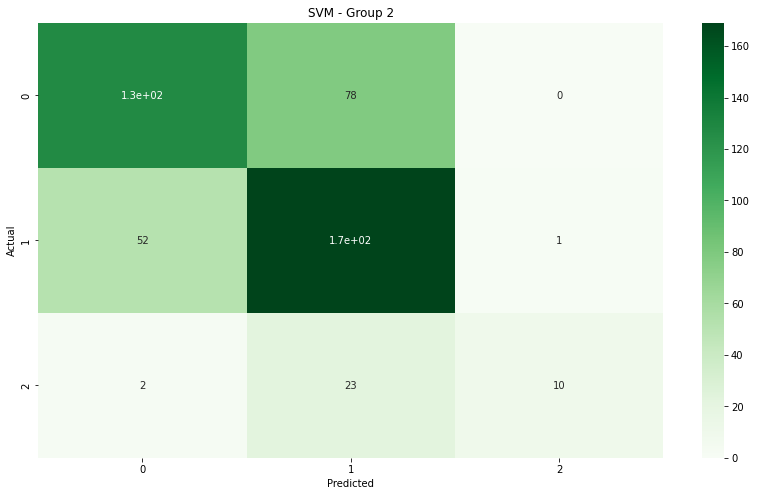

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5103238962393892; Accuracy score = 0.5757575757575758 ; Precisison Score = 0.4678753989098816; Recall score = 0.5757575757575758


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        34
           1       0.00      0.00      0.00        16
           2       0.38      0.69      0.49        16

    accuracy                           0.58        66
   macro avg       0.37      0.49      0.42        66
weighted avg       0.47      0.58      0.51        66



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

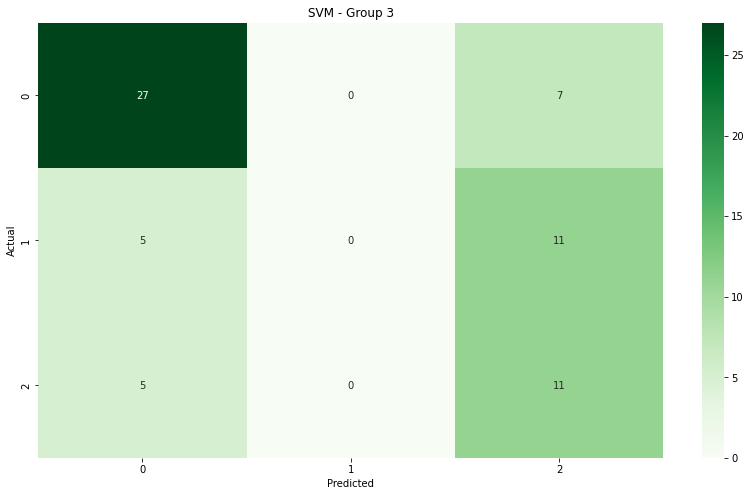

In [189]:
lst_label_np = [label_merged_np, label_merged_non_noisy_np, label_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df, standardized_mergedlabels_non_noisy_df, standardized_mergedlabels_noisy_df]
X_test_list = [None,None,None]
kernel = ['rbf', 'rbf', 'linear']
c = [10, 10, 0.1]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma='scale', C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2'])

Improvements in all but noisy, it seems to still not be able to predict anything but the extreme classes



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.57      0.56        63
           1       0.61      0.73      0.67       100
           2       0.77      0.40      0.52        43

    accuracy                           0.61       206
   macro avg       0.65      0.57      0.58       206
weighted avg       0.63      0.61      0.60       206



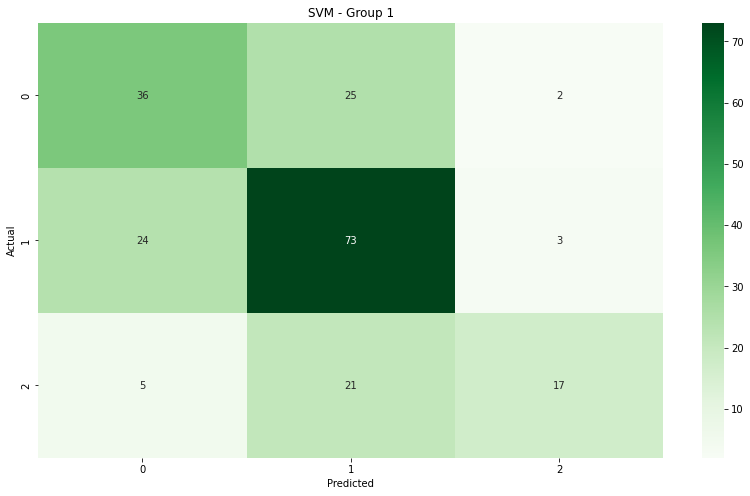



 Aggregate report 
               precision    recall  f1-score   support

           0       0.58      0.62      0.60        47
           1       0.63      0.81      0.71        88
           2       1.00      0.18      0.31        33

    accuracy                           0.63       168
   macro avg       0.74      0.54      0.54       168
weighted avg       0.69      0.63      0.60       168



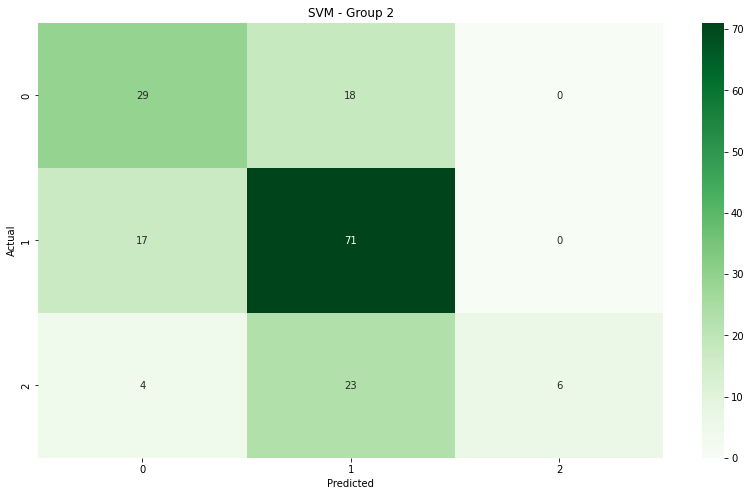



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        18
           1       0.00      0.00      0.00        10
           2       0.56      1.00      0.71        10

    accuracy                           0.61        38
   macro avg       0.40      0.57      0.47        38
weighted avg       0.45      0.61      0.51        38



c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

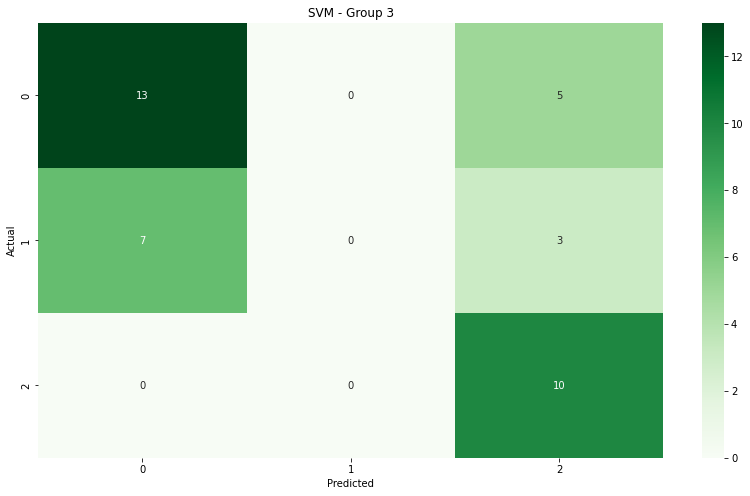

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,2,1
1,0202on89vhz61,0,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,1,1
4,095x9borh0z61,1,1
...,...,...,...
201,wspxs1zbhm671,1,1
202,wunn1jjbpu961,0,0
203,wunqa6kfsvx51,0,0
204,xdz15thrnem51,1,1


In [191]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

max_parent_df_list[0] 

again we see improvements

### Try balancing levels with 4 classes

In [18]:
from sklearn.utils import resample

In [19]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


In [20]:
#check initial size
print(standardized_aggression_df.shape)

(2110, 14)


In [21]:
# Separate classes
level0 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 0]
level1 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 1]
level2 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 2]
level3 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(915, 14)
(612, 14)
(364, 14)
(219, 14)


In [22]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_aggression_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(612, 14)
(600, 14)
(600, 14)


check that it is now balanced

In [23]:
print(standardized_aggression_df_balanced.shape)

(2412, 14)


In [24]:
level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance

level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(612, 14)
(600, 14)
(600, 14)
(348, 14)
(433, 14)
(561, 14)
(1070, 14)


now for non noisy

In [25]:
print(standardized_non_noisy_df.shape)

(1848, 14)


In [26]:
# Separate classes
level0 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 2]
level3 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(778, 14)
(593, 14)
(331, 14)
(146, 14)


In [27]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_non_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(593, 14)
(600, 14)
(600, 14)


In [28]:
print(standardized_non_noisy_df_balanced.shape)

(2393, 14)


In [29]:
level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent label balance

level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(593, 14)
(600, 14)
(600, 14)
(312, 14)
(436, 14)
(553, 14)
(1092, 14)


now for noisy

In [30]:
print(standardized_noisy_df.shape)

(262, 14)


In [31]:
# Separate classes
level0 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 0]
level1 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 1]
level2 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 2]
level3 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(137, 14)
(19, 14)
(33, 14)
(73, 14)


In [32]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=75)

#level3 close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(75, 14)
(75, 14)
(75, 14)
(73, 14)


check

In [33]:
print(standardized_noisy_df_balanced.shape)

(298, 14)


In [34]:
level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance 

level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(75, 14)
(75, 14)
(75, 14)
(73, 14)
(63, 14)
(74, 14)
(26, 14)
(135, 14)


all parents are now more unbalanced, but this should be OK because we are not training on them

rebuild the svm

In [35]:
data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_np = standardized_aggression_df_balanced['segment_label_train'].to_numpy()
label_balanced_np=label_balanced_np.astype('int')

data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_non_noisy_np = standardized_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_non_noisy_np=label_balanced_non_noisy_np.astype('int')

data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_noisy_np = standardized_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_noisy_np=label_balanced_noisy_np.astype('int')

C:\Users\Paige\AppData\Local\Temp\ipykernel_3508\917994061.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_3508\917994061.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_3508\917994061.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train

In [313]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [1000, 10000,100000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_np, label_balanced_np, quick_parameters)

{'C': 100000, 'gamma': 'auto', 'kernel': 'rbf'}


In [305]:
quick_parameters = {'C': [100, 1000, 10000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
hyperparameter_tuning(svc, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}


{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

In [311]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'C': [ 100, 1000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2,3,4]}
hyperparameter_tuning(svc, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


{'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6576262674475774; Accuracy score = 0.6699834162520729 ; Precisison Score = 0.659213927222173; Recall score = 0.6699834162520729


 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.55      0.56       150
           1       0.56      0.40      0.47       156
           2       0.64      0.84      0.73       141
           3       0.85      0.91      0.88       156

    accuracy                           0.67       603
   macro avg       0.66      0.67      0.66       603
weighted avg       0.66      0.67      0.66       603



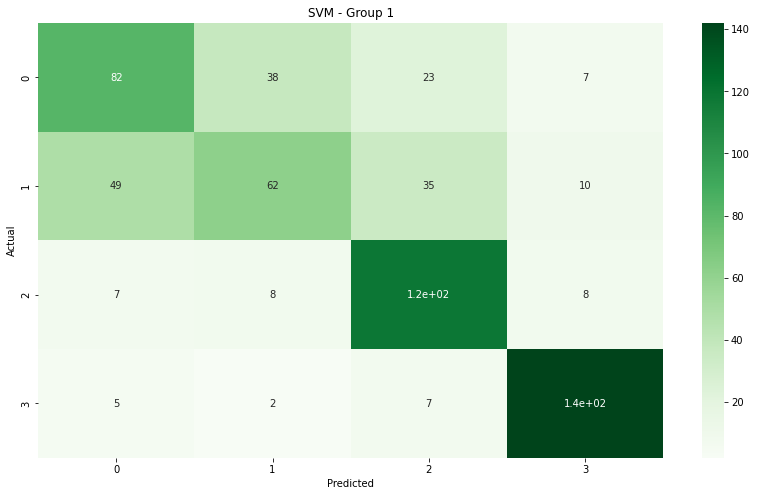

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7201231276563288; Accuracy score = 0.7296849087893864 ; Precisison Score = 0.7207833021872582; Recall score = 0.7296849087893864


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.68      0.66       149
           1       0.65      0.47      0.54       150
           2       0.76      0.82      0.79       151
           3       0.83      0.95      0.88       153

    accuracy                           0.73       603
   macro avg       0.72      0.73      0.72       603
weighted avg       0.72      0.73      0.72       603



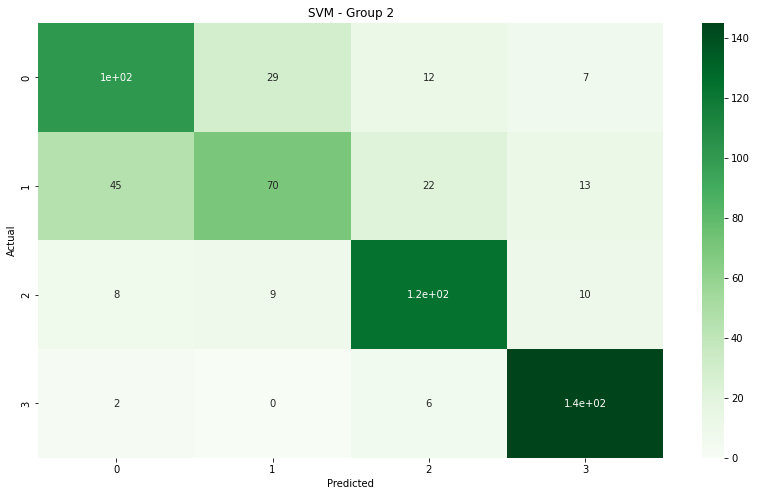

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7465318303811057; Accuracy score = 0.76 ; Precisison Score = 0.7630872830872831; Recall score = 0.76


 Aggregate report 
               precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.78      0.91      0.84        23
           2       0.73      0.95      0.83        20
           3       0.73      0.50      0.59        16

    accuracy                           0.76        75
   macro avg       0.76      0.73      0.73        75
weighted avg       0.76      0.76      0.75        75



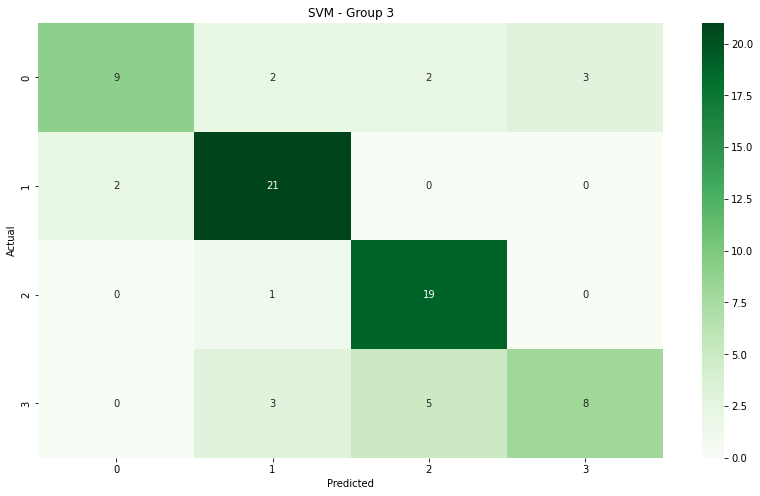

In [147]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.50      0.57        64
           1       0.43      0.38      0.40        52
           2       0.59      0.78      0.67        50
           3       0.75      0.81      0.78        47

    accuracy                           0.61       213
   macro avg       0.60      0.62      0.60       213
weighted avg       0.60      0.61      0.60       213



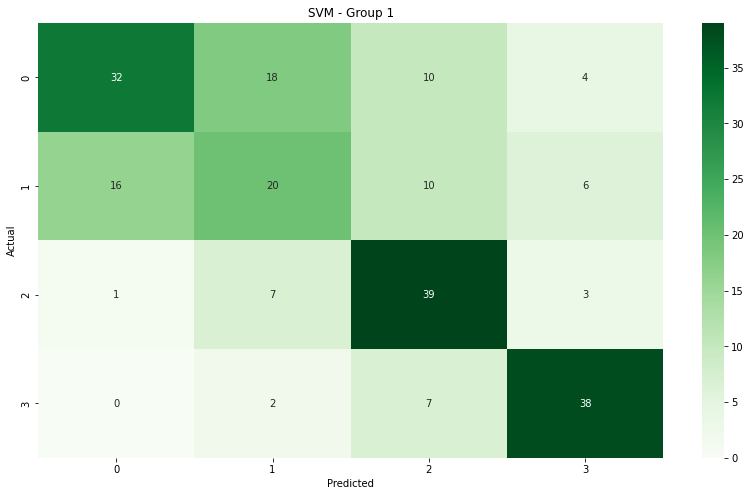



 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.72      0.72        60
           1       0.50      0.40      0.44        48
           2       0.60      0.74      0.66        46
           3       0.76      0.76      0.76        50

    accuracy                           0.66       204
   macro avg       0.65      0.65      0.65       204
weighted avg       0.65      0.66      0.65       204



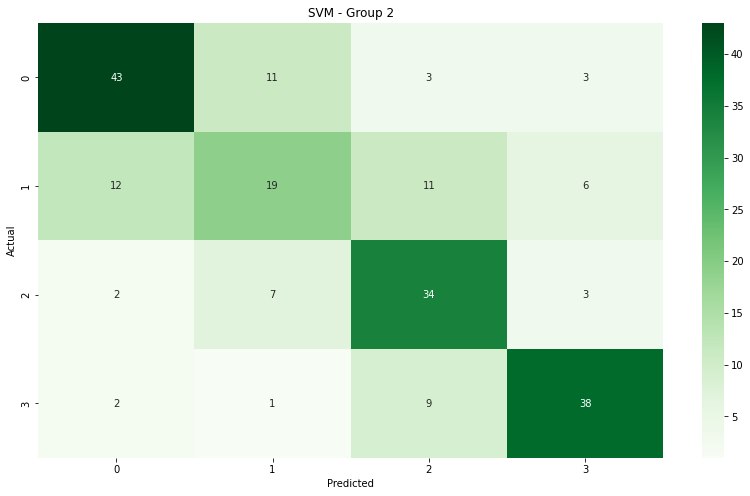



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.50      1.00      0.67         4
           2       0.27      0.60      0.37         5
           3       0.73      0.53      0.62        15

    accuracy                           0.58        36
   macro avg       0.62      0.66      0.58        36
weighted avg       0.73      0.58      0.60        36



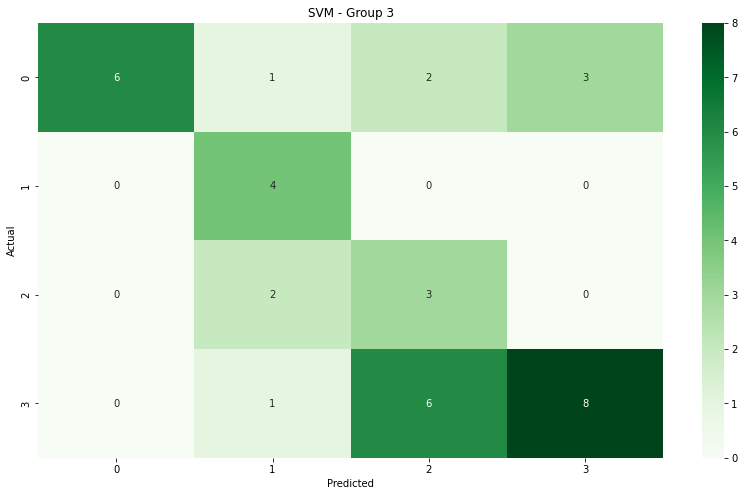

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt62,0,3
1,01avx2fm1t961,3,3
2,0202on89vhz61,0,3
3,03mglec8fez51,1,1
4,0653ipqy7vd71,2,2
...,...,...,...
208,xan1gwbxrwc61,0,2
209,xc76oggvh2471,1,2
210,xda96lajcd871,0,0
211,xdz15thrnem51,2,2


In [63]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]    

# This is the data we choose to move forward with

### test both balancing the data and combining levels 1 and 2

In [44]:
print(standardized_aggression_mergedlabels_df.shape)

(2110, 14)


In [45]:
# Separate classes
level0 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(219, 14)


In [46]:
#level0 close enough

#level1 close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=900)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_aggression_mergedlabels_df_balanced = pd.concat([level0, level1, level2])

(915, 14)
(976, 14)
(900, 14)


In [47]:
print(standardized_aggression_mergedlabels_df_balanced.shape)

(2791, 14)


In [48]:
level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(900, 14)
(536, 14)
(956, 14)
(1299, 14)


non noisy

In [49]:
print(standardized_mergedlabels_non_noisy_df.shape)

(1848, 14)


In [50]:
# Separate classes
level0 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(924, 14)
(146, 14)


In [51]:
#level0 close enough

#level1 close enough
# Downsample 0 class
level1 = resample(level1, replace=False,n_samples=775)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=775)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_non_noisy_df_balanced = pd.concat([level0, level1, level2])

(778, 14)
(775, 14)
(775, 14)


In [52]:
print(standardized_mergedlabels_non_noisy_df_balanced.shape)

(2328, 14)


In [53]:
level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(775, 14)
(775, 14)
(418, 14)
(805, 14)
(1105, 14)


noisy

In [54]:
print(standardized_mergedlabels_noisy_df.shape)

(262, 14)


In [55]:
# Separate classes
level0 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(137, 14)
(52, 14)
(73, 14)


In [56]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#level3 is close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_noisy_df_balanced = pd.concat([level0, level1, level2])

(75, 14)
(75, 14)
(73, 14)


In [57]:
print(standardized_mergedlabels_noisy_df_balanced.shape)

(223, 14)


In [58]:
level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(75, 14)
(75, 14)
(73, 14)
(62, 14)
(50, 14)
(111, 14)


rebuild the svm

In [59]:
data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_np=label_balanced_merged_np.astype('int')

data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_non_noisy_np=label_balanced_merged_non_noisy_np.astype('int')

data_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_noisy_np=label_balanced_merged_noisy_np.astype('int')

C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\Paige\AppData\Local\Temp\ipykernel_10700\4173322112.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_noisy_np = st

In [286]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [0.01, 0.1, 1, 10], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_merged_np, label_balanced_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_non_noisy_np, label_balanced_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_noisy_np, label_balanced_merged_noisy_np, quick_parameters)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7052997420381426; Accuracy score = 0.7063037249283668 ; Precisison Score = 0.7077463532542837; Recall score = 0.7063037249283668


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.63      0.68       243
           1       0.62      0.66      0.64       248
           2       0.79      0.85      0.82       207

    accuracy                           0.71       698
   macro avg       0.71      0.71      0.71       698
weighted avg       0.71      0.71      0.71       698



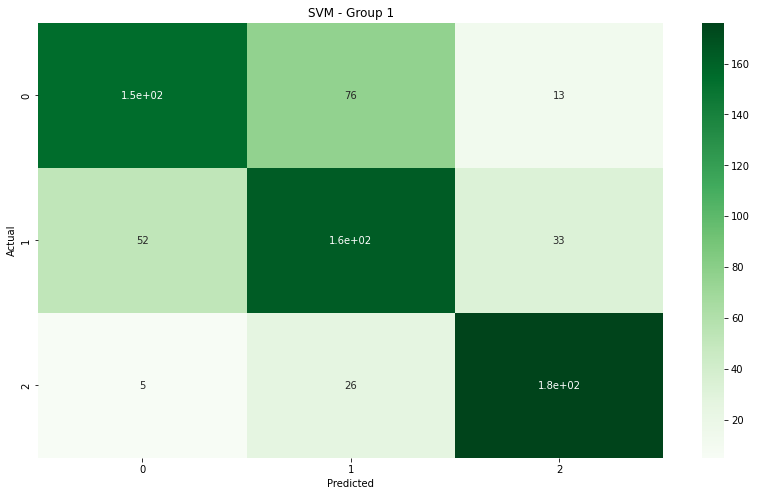

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7546679251823717; Accuracy score = 0.7577319587628866 ; Precisison Score = 0.7557098774572135; Recall score = 0.7577319587628866


 Aggregate report 
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       203
           1       0.67      0.66      0.66       192
           2       0.81      0.93      0.86       187

    accuracy                           0.76       582
   macro avg       0.76      0.76      0.76       582
weighted avg       0.76      0.76      0.75       582



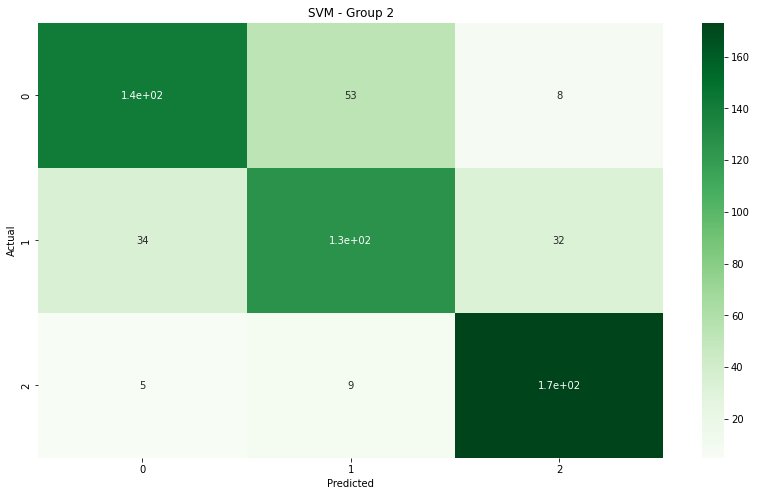

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6955042332011574; Accuracy score = 0.6964285714285714 ; Precisison Score = 0.7012533274179237; Recall score = 0.6964285714285714


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.63      0.63      0.63        19
           2       0.70      0.80      0.74        20

    accuracy                           0.70        56
   macro avg       0.70      0.69      0.70        56
weighted avg       0.70      0.70      0.70        56



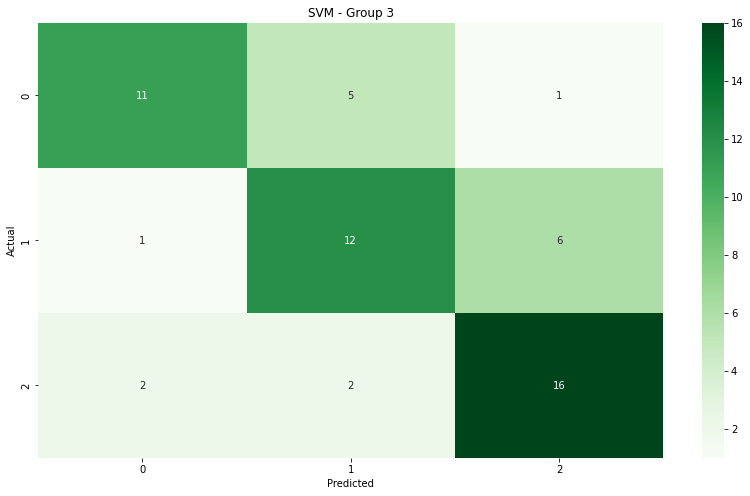

In [60]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_merged_np, label_balanced_merged_non_noisy_np, label_balanced_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df_balanced, standardized_mergedlabels_non_noisy_df_balanced, standardized_mergedlabels_noisy_df_balanced]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=10)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1', '2'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.56      0.60        66
           1       0.62      0.62      0.62        87
           2       0.67      0.76      0.71        55

    accuracy                           0.64       208
   macro avg       0.64      0.65      0.64       208
weighted avg       0.64      0.64      0.64       208



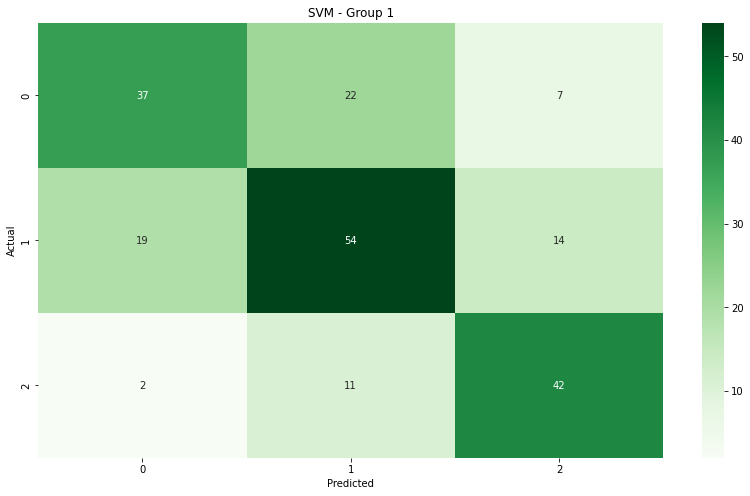



 Aggregate report 
               precision    recall  f1-score   support

           0       0.49      0.49      0.49        47
           1       0.68      0.61      0.65        83
           2       0.62      0.76      0.68        37

    accuracy                           0.61       167
   macro avg       0.60      0.62      0.61       167
weighted avg       0.61      0.61      0.61       167



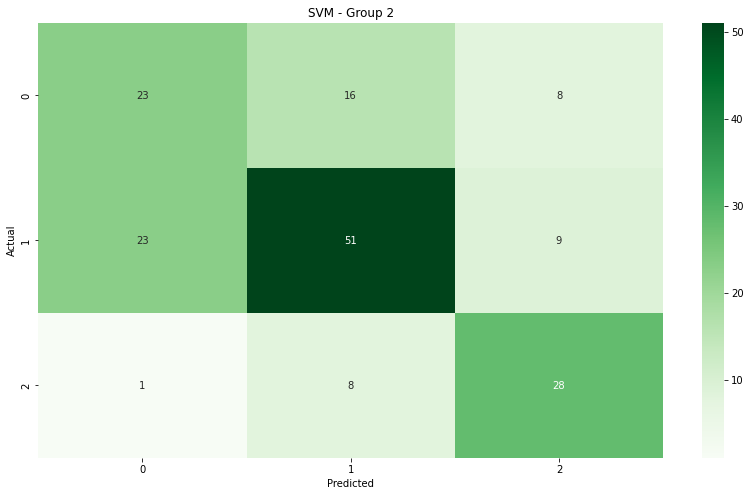



 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.43      0.75      0.55         8
           2       0.75      0.50      0.60        12

    accuracy                           0.56        32
   macro avg       0.59      0.58      0.56        32
weighted avg       0.61      0.56      0.57        32



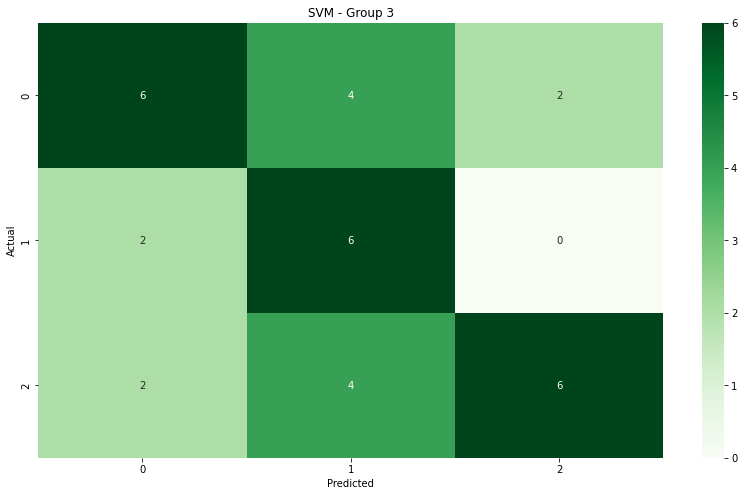

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt61,0,2
1,01avx2fm1t961,2,1
2,03mglec8fez51,1,1
3,0653ipqy7vd71,1,2
4,065hfyuu0ya61,0,1
...,...,...,...
203,wunqa6kfsvx51,0,1
204,xan1gwbxrwc61,0,0
205,xbw64yf04th51,1,0
206,xdz15thrnem51,1,2


In [290]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

max_parent_df_list[0]    

perhaps for noisy because everything is so loud we can only get binary classification?

In [294]:
standardized_aggression_binary_df = standardized_aggression_df.copy()
standardized_binary_noisy_df = standardized_aggression_binary_df.loc[standardized_aggression_binary_df['noisy_train'] == 1]
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 3, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 1, 'parent_label_train'] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 3, 'parent_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 2, 'parent_label_train'] = 1
print(standardized_binary_noisy_df['segment_label_train'].unique())
print(standardized_binary_noisy_df['parent_label_train'].unique())

C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\2694918186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

[0 1]
[0 1]


In [295]:
data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_binary_noisy_np = standardized_binary_noisy_df['segment_label_train'].to_numpy()
label_binary_noisy_np=label_binary_noisy_np.astype('int')

C:\Users\Paige\AppData\Local\Temp\ipykernel_10828\524940715.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()


In [296]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_binary_noisy_np, label_binary_noisy_np, quick_parameters)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [299]:
# Separate classes
level0 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 0]
level1 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1]

print(level0.shape)
print(level1.shape)

(156, 14)
(106, 14)


already pretty balanced no need to change it

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8190362269309637; Accuracy score = 0.8181818181818182 ; Precisison Score = 0.821401338642718; Recall score = 0.8181818181818182


 Aggregate report 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        39
           1       0.76      0.81      0.79        27

    accuracy                           0.82        66
   macro avg       0.81      0.82      0.81        66
weighted avg       0.82      0.82      0.82        66



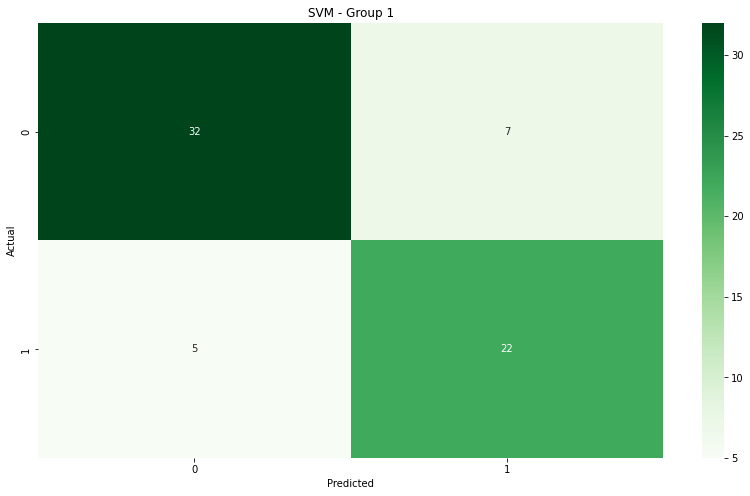

In [303]:
label = 'segment_label_train'
X_test_list = [None]

svm_model = svm.SVC(kernel='linear', gamma='scale', C=0.1)
actual, predicted, X_test_list[0] = run_model(svm_model, standardized_binary_noisy_df,  label_binary_noisy_np,label_name=label)

confusion_matrix_graph(f"SVM - Group {i+1}", actual, predicted, ['0', '1'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.65      0.73      0.69        15

    accuracy                           0.72        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.73      0.72      0.72        36



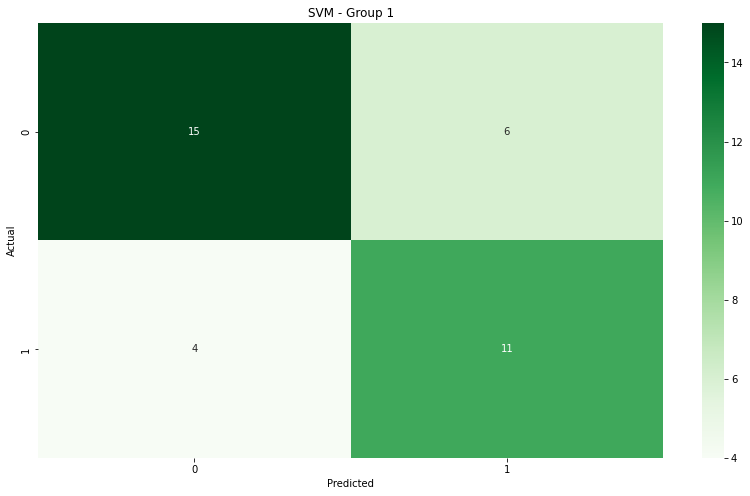

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,1,1
1,143mdsnmvu461,1,1
2,16dnw24q0jo51,0,0
3,1fhp1vuk9h461,0,0
4,1sm6gyfaqyb71,1,1
5,37gpiutnlqj51,0,0
6,3duf3yestck51,1,1
7,3nr00989hhp51,1,0
8,3nvn1lwacgg61,0,0
9,hv7owj844s461,1,1


In [304]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1'])

max_parent_df_list[0]

This seems to be the way to go for noisy, middle levels cannot be teased out with the background sound and overlapping voices

## Conclusions:

### We can get slightly better models (approx 8%) by combining the levels, however, this is further from our original research question and it is more interesting to classify both noisy and non-noisy with the same levels. Because of this we will select balanced sampled original (4 class) classification, to conintue onto the other models

# KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
# knn.fit(X, y)
# KNeighborsClassifier()
k_range = list(range(1, 31))

In [ ]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_np, label_balanced_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6767321545895599; Accuracy score = 0.6865671641791045 ; Precisison Score = 0.6771937932725478; Recall score = 0.6865671641791045


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.50      0.56       152
           1       0.58      0.51      0.55       150
           2       0.68      0.82      0.75       157
           3       0.81      0.92      0.86       144

    accuracy                           0.69       603
   macro avg       0.68      0.69      0.68       603
weighted avg       0.68      0.69      0.68       603



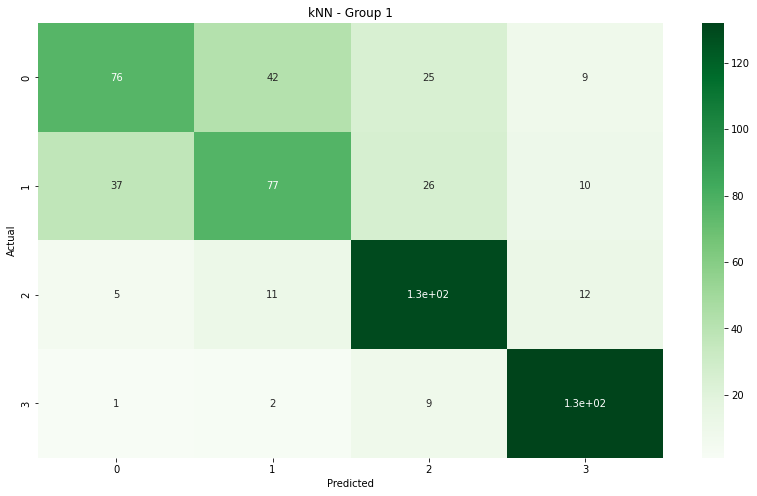

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.714049623519219; Accuracy score = 0.7197346600331676 ; Precisison Score = 0.7119100771375347; Recall score = 0.7197346600331676


 Aggregate report 
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       147
           1       0.56      0.53      0.55       146
           2       0.76      0.84      0.80       148
           3       0.85      0.92      0.88       162

    accuracy                           0.72       603
   macro avg       0.71      0.71      0.71       603
weighted avg       0.71      0.72      0.71       603



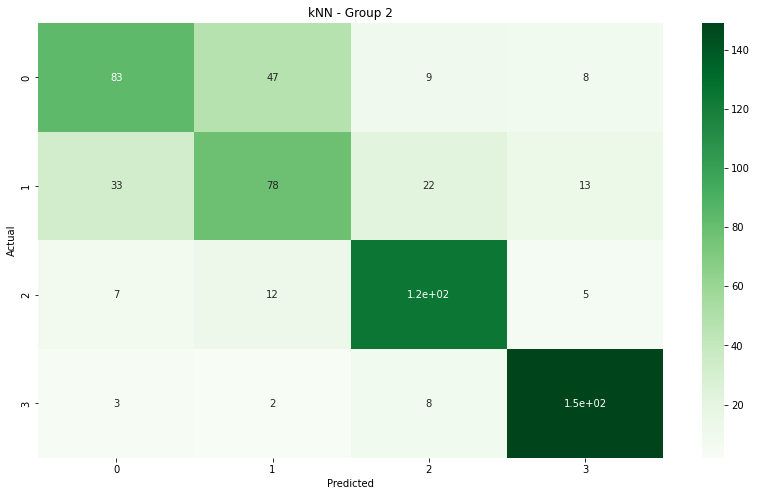

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7839413045584153; Accuracy score = 0.7866666666666666 ; Precisison Score = 0.7897821350762527; Recall score = 0.7866666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.94      0.89      0.92        19
           2       0.76      0.93      0.84        14
           3       0.71      0.77      0.74        22

    accuracy                           0.79        75
   macro avg       0.79      0.80      0.79        75
weighted avg       0.79      0.79      0.78        75



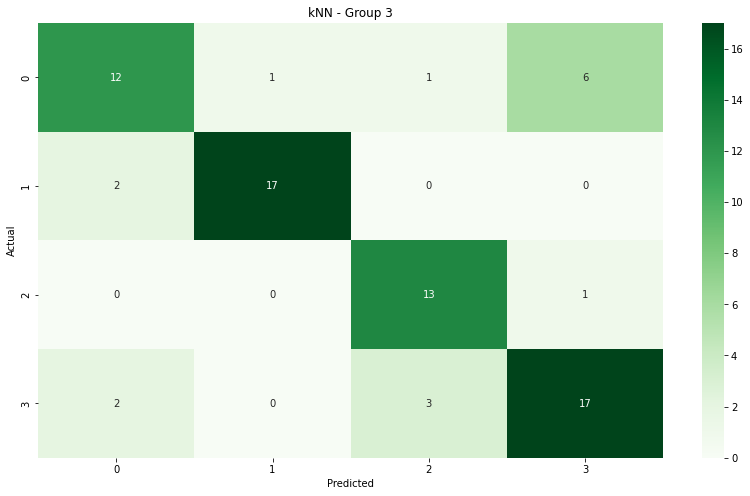

In [155]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual, predicted, X_test_list[i] = run_model(knn, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"kNN - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.43      0.49        54
           1       0.56      0.44      0.49        52
           2       0.48      0.70      0.57        46
           3       0.67      0.72      0.70        54

    accuracy                           0.57       206
   macro avg       0.57      0.57      0.56       206
weighted avg       0.58      0.57      0.56       206



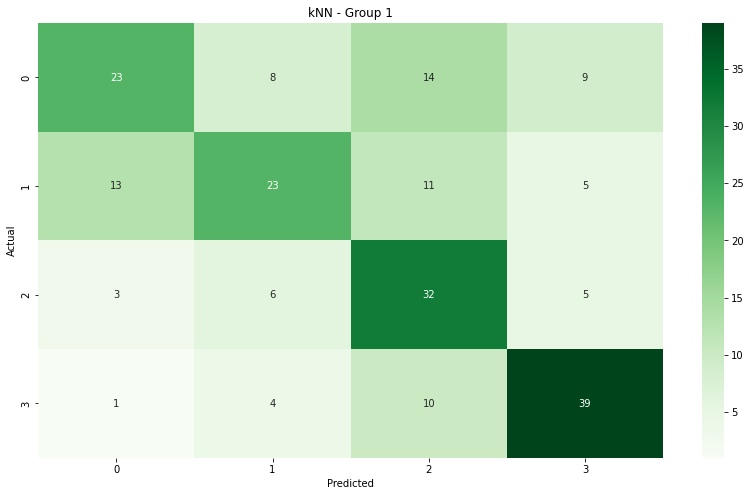



 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.53      0.60        53
           1       0.55      0.55      0.55        51
           2       0.61      0.71      0.66        49
           3       0.75      0.81      0.78        48

    accuracy                           0.65       201
   macro avg       0.65      0.65      0.65       201
weighted avg       0.65      0.65      0.64       201



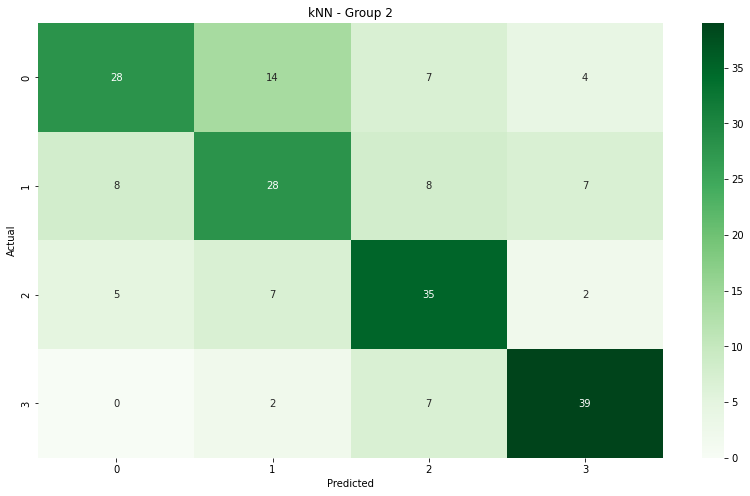



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.60      0.60      0.60         5
           2       0.33      0.75      0.46         4
           3       0.53      0.57      0.55        14

    accuracy                           0.62        39
   macro avg       0.62      0.64      0.60        39
weighted avg       0.71      0.62      0.64        39



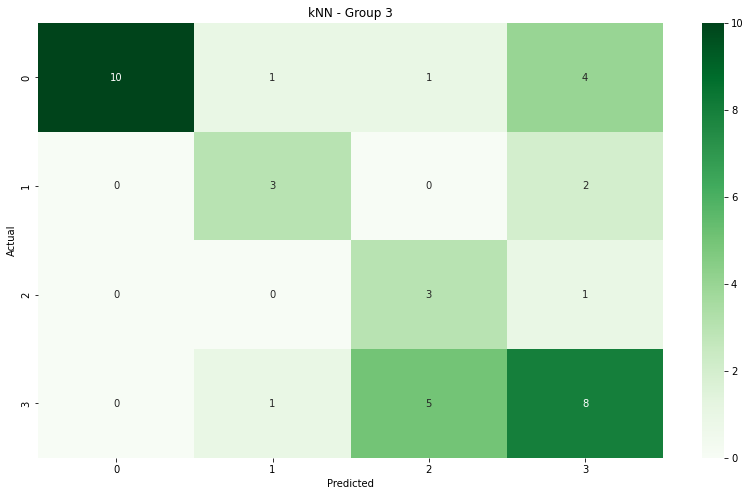

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,3
1,03mglec8fez51,1,2
2,0653ipqy7vd71,2,2
3,08ss0a3zs0061,2,2
4,095x9borh0z61,2,1
...,...,...,...
201,xbw64yf04th51,1,1
202,xc76oggvh2471,1,1
203,xda96lajcd871,0,0
204,xdz15thrnem51,2,2


In [156]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"kNN - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]    

# Tree based models

In [46]:
# Load Library
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

### Decision Tree

In [ ]:
quick_parameters = {'criterion' : ['gini', 'entropy'], 'max_depth' : [2,4,6,8,10,12,14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]}

dtree = DecisionTreeClassifier()
hyperparameter_tuning(dtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning(dtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning(dtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'criterion': 'entropy', 'max_depth': 30}
{'criterion': 'entropy', 'max_depth': 20}
{'criterion': 'gini', 'max_depth': 18}


{'criterion': 'entropy', 'max_depth': 30}

{'criterion': 'entropy', 'max_depth': 20}

{'criterion': 'gini', 'max_depth': 18}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6538345769791037; Accuracy score = 0.6633499170812603 ; Precisison Score = 0.6552760612985645; Recall score = 0.6633499170812603


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.49      0.55       154
           1       0.52      0.45      0.48       148
           2       0.62      0.81      0.70       131
           3       0.83      0.89      0.86       170

    accuracy                           0.66       603
   macro avg       0.65      0.66      0.65       603
weighted avg       0.66      0.66      0.65       603



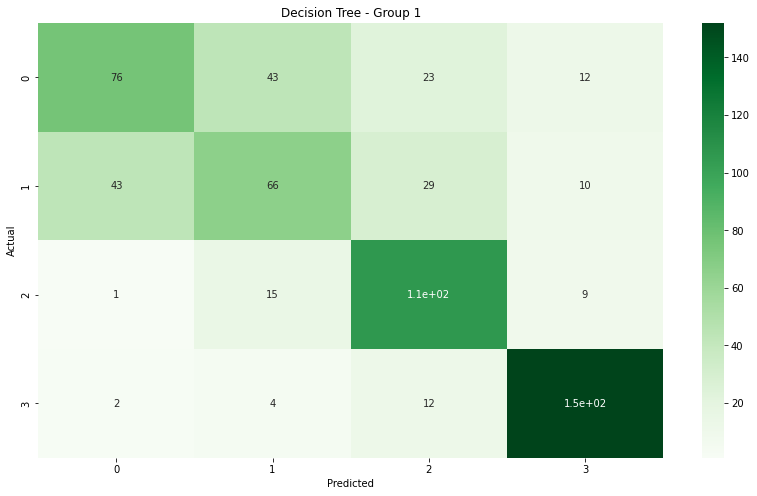

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6924201660555124; Accuracy score = 0.703150912106136 ; Precisison Score = 0.6882056343189723; Recall score = 0.703150912106136


 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.50      0.55       141
           1       0.53      0.47      0.50       151
           2       0.75      0.87      0.81       159
           3       0.85      0.95      0.90       152

    accuracy                           0.70       603
   macro avg       0.69      0.70      0.69       603
weighted avg       0.69      0.70      0.69       603



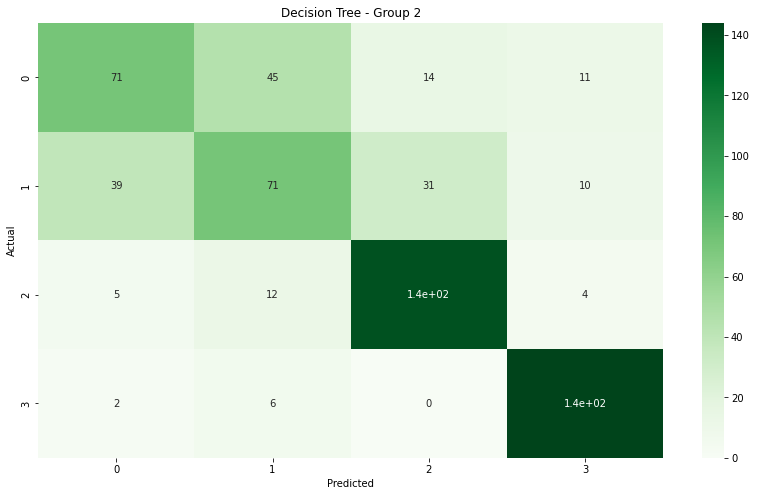

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7675555555555555; Accuracy score = 0.7733333333333333 ; Precisison Score = 0.7752328281740047; Recall score = 0.7733333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.85      1.00      0.92        22
           2       0.65      0.79      0.71        14
           3       0.78      0.64      0.70        22

    accuracy                           0.77        75
   macro avg       0.76      0.77      0.76        75
weighted avg       0.78      0.77      0.77        75



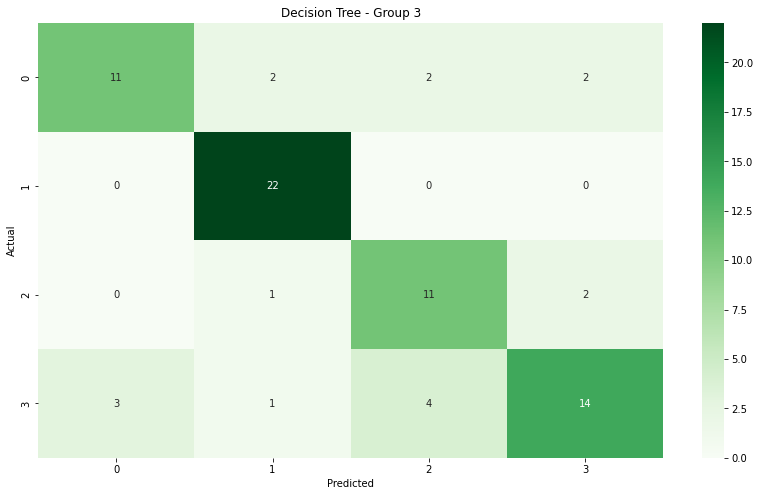

In [157]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual, predicted, X_test_list[i] = run_model(dtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Decision Tree - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.56      0.39      0.46        56
           1       0.51      0.38      0.44        47
           2       0.52      0.69      0.59        48
           3       0.61      0.78      0.68        49

    accuracy                           0.56       200
   macro avg       0.55      0.56      0.54       200
weighted avg       0.55      0.56      0.54       200



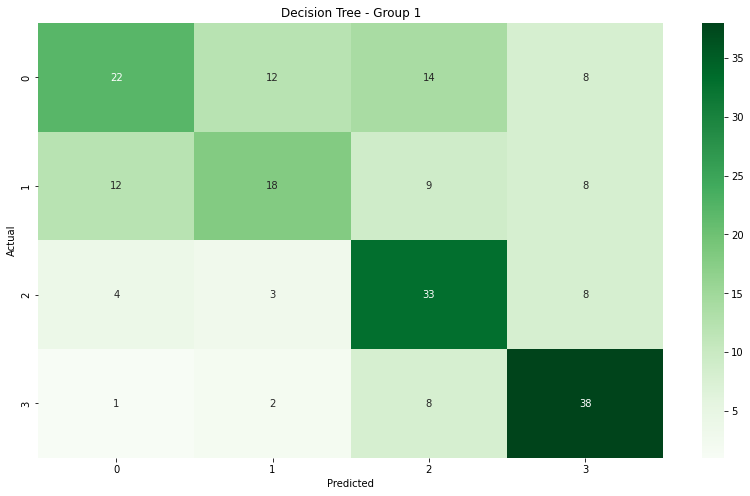



 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.43      0.53        51
           1       0.48      0.42      0.44        48
           2       0.59      0.78      0.67        46
           3       0.62      0.77      0.69        43

    accuracy                           0.59       188
   macro avg       0.59      0.60      0.58       188
weighted avg       0.59      0.59      0.58       188



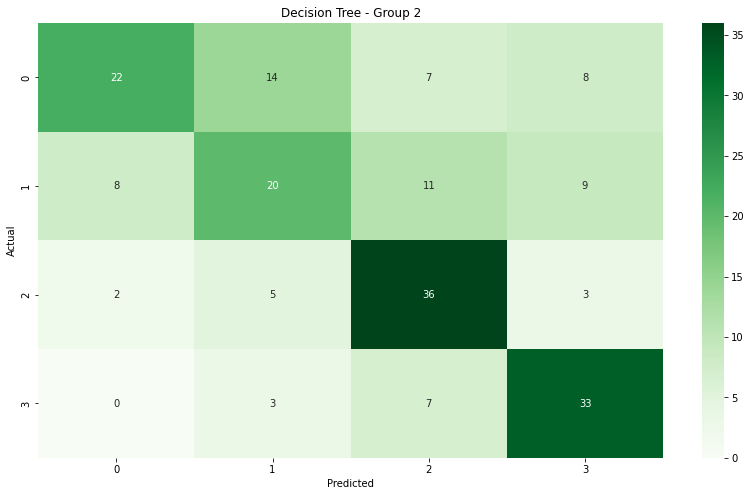



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.56      0.71      0.63         7
           2       0.33      0.50      0.40         6
           3       0.73      0.57      0.64        14

    accuracy                           0.57        40
   macro avg       0.56      0.58      0.56        40
weighted avg       0.61      0.57      0.58        40



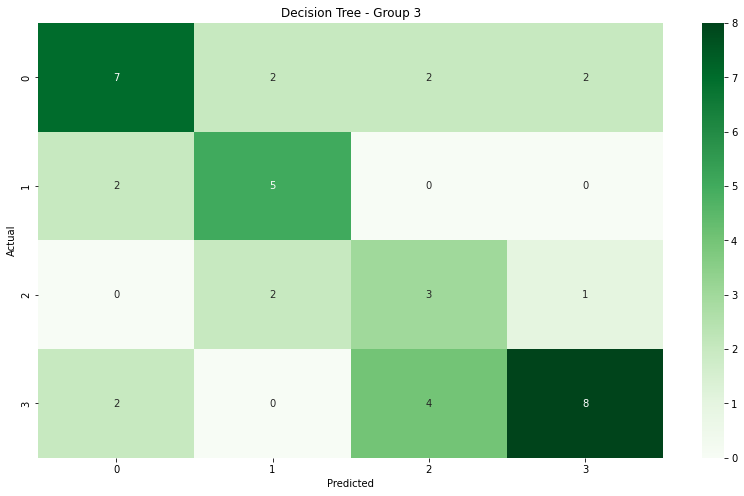

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt62,0,3
1,01avx2fm1t961,3,3
2,03mglec8fez51,1,3
3,0653ipqy7vd71,2,2
4,065hfyuu0ya61,0,1
...,...,...,...
195,x9i397iuxh971,2,2
196,xan1gwbxrwc61,0,2
197,xbw64yf04th51,1,0
198,xdz15thrnem51,2,2


In [158]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Decision Tree - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

## Random Forest

use random search to speed up the grid search (was taking 12h+)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def hyperparameter_tuning_random(ml_model, data, label, parameters):
    clf = RandomizedSearchCV(ml_model, parameters, n_iter = 50, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

In [ ]:
quick_parameters = {
  'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
  'max_features' : ['auto', 'sqrt'],
  'max_depth' : [int(x) for x in np.linspace(10, 150, num = 11)],
  'min_samples_split' : [2, 5, 10, 15],
  'min_samples_leaf' : [1, 2, 4],
  'bootstrap' : [True, False],
}

rtree = RandomForestClassifier()
hyperparameter_tuning_random(rtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(rtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(rtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 122, 'bootstrap': False}
{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': False}
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 122, 'bootstrap': False}

{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': False}

{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6776726167098867; Accuracy score = 0.6849087893864013 ; Precisison Score = 0.6777595484863039; Recall score = 0.6849087893864013


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.51      0.57       159
           1       0.57      0.55      0.56       159
           2       0.68      0.80      0.73       137
           3       0.83      0.92      0.87       148

    accuracy                           0.68       603
   macro avg       0.68      0.69      0.68       603
weighted avg       0.68      0.68      0.68       603



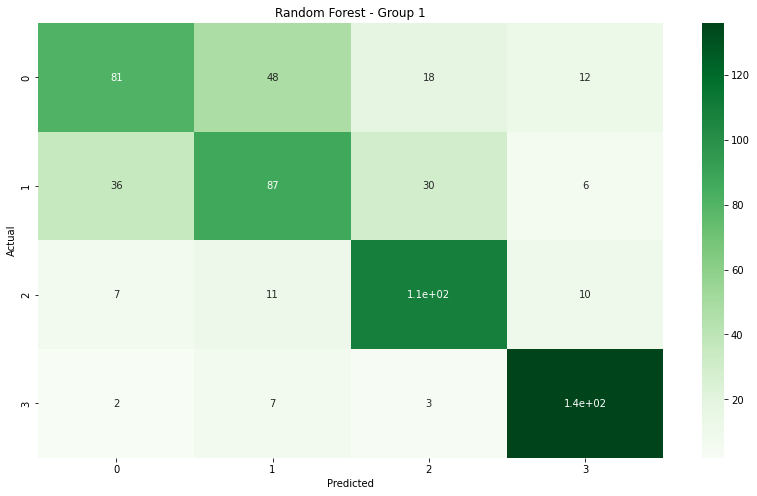

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7477347240004258; Accuracy score = 0.7512437810945274 ; Precisison Score = 0.7455066714358491; Recall score = 0.7512437810945274


 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       136
           1       0.61      0.56      0.58       149
           2       0.77      0.78      0.77       159
           3       0.89      0.95      0.92       159

    accuracy                           0.75       603
   macro avg       0.74      0.75      0.74       603
weighted avg       0.75      0.75      0.75       603



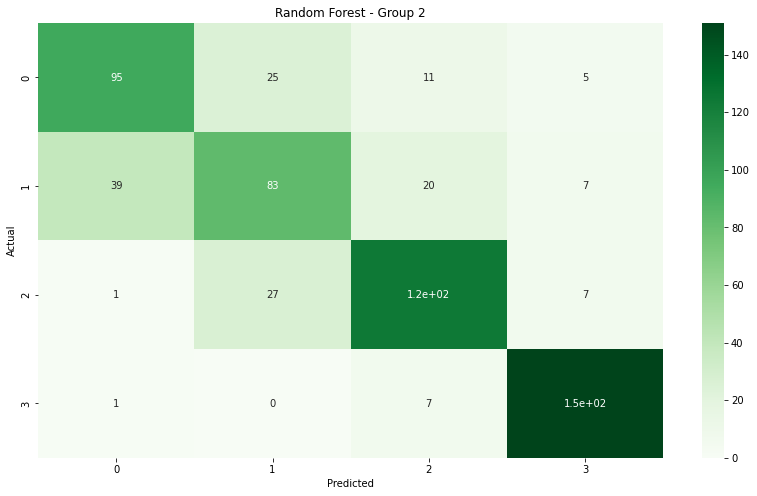

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7681373823309308; Accuracy score = 0.7733333333333333 ; Precisison Score = 0.780383567614689; Recall score = 0.7733333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       1.00      1.00      1.00        19
           2       0.65      0.94      0.77        16
           3       0.68      0.57      0.62        23

    accuracy                           0.77        75
   macro avg       0.78      0.79      0.77        75
weighted avg       0.78      0.77      0.77        75



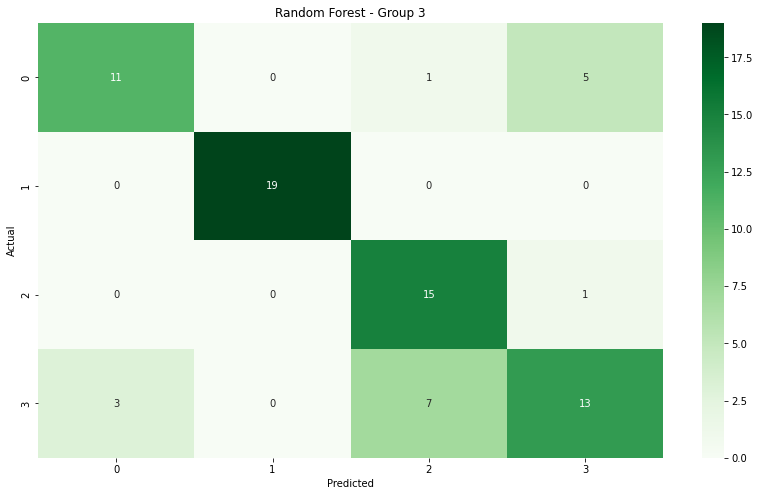

In [ ]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual, predicted, X_test_list[i] = run_model(rtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Random Forest - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.47      0.54        53
           1       0.52      0.48      0.50        48
           2       0.62      0.74      0.67        46
           3       0.68      0.80      0.73        50

    accuracy                           0.62       197
   macro avg       0.61      0.62      0.61       197
weighted avg       0.62      0.62      0.61       197



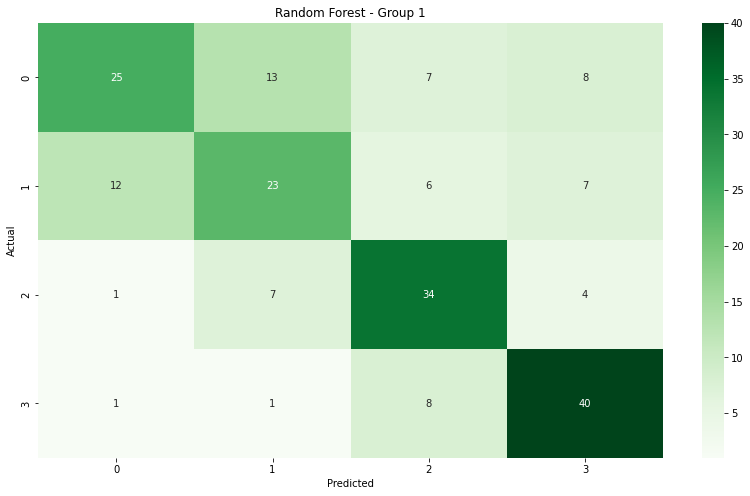



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.62      0.64        56
           1       0.54      0.47      0.50        45
           2       0.62      0.69      0.65        48
           3       0.77      0.82      0.79        49

    accuracy                           0.65       198
   macro avg       0.64      0.65      0.65       198
weighted avg       0.65      0.65      0.65       198



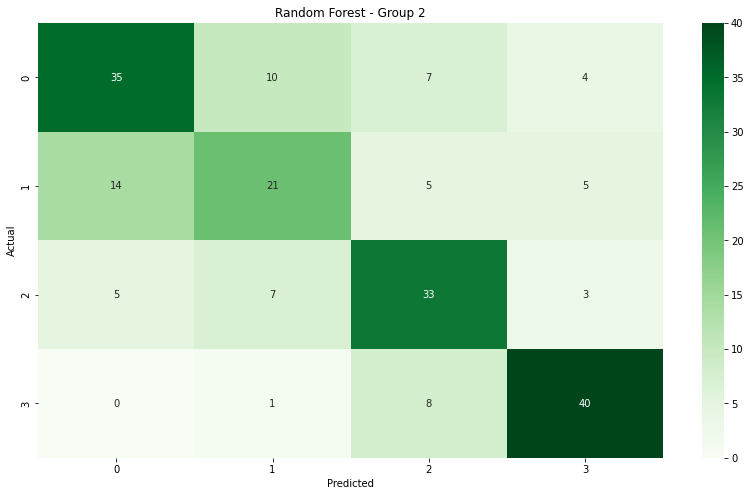



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.60      0.60      0.60         5
           2       0.44      0.80      0.57         5
           3       0.67      0.67      0.67        15

    accuracy                           0.68        38
   macro avg       0.68      0.69      0.66        38
weighted avg       0.74      0.68      0.70        38



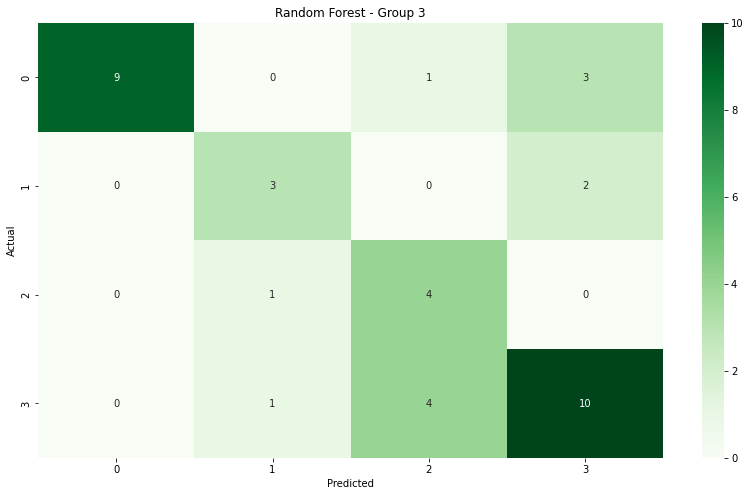

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt61,0,3
1,01avx2fm1t961,3,3
2,03mglec8fez51,1,1
3,0653ipqy7vd71,2,2
4,08ss0a3zs0061,2,2
...,...,...,...
192,wunn1jjbpu961,0,1
193,wunqa6kfsvx51,0,1
194,x705shsub7m61,1,1
195,xdz15thrnem51,2,3


In [ ]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

## Ada Boost

adaboost with decision tree base

In [ ]:
quick_parameters = {
  'base_estimator' : [dtree],
  'n_estimators' : [10, 20, 50, 100],
  'learning_rate' : [ 0.01, 0.1, 1, 10]
}

adtree = AdaBoostClassifier()
hyperparameter_tuning(adtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning(adtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning(adtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 50}
{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 20}
{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 0.1, 'n_estimators': 20}


{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 50}

{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 20}

{'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 0.1, 'n_estimators': 20}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.687781142535265; Accuracy score = 0.6948590381426202 ; Precisison Score = 0.6909124733656549; Recall score = 0.6948590381426202


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.54      0.58       141
           1       0.63      0.51      0.56       154
           2       0.63      0.81      0.71       139
           3       0.85      0.91      0.88       169

    accuracy                           0.69       603
   macro avg       0.68      0.69      0.68       603
weighted avg       0.69      0.69      0.69       603



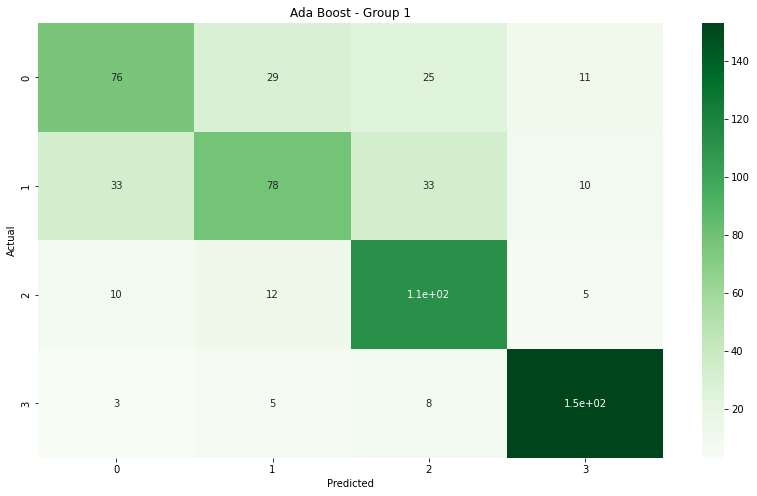

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6742166401917637; Accuracy score = 0.6849087893864013 ; Precisison Score = 0.6708258556292663; Recall score = 0.6849087893864013


 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.44      0.49       140
           1       0.52      0.52      0.52       163
           2       0.78      0.83      0.80       164
           3       0.82      0.97      0.89       136

    accuracy                           0.68       603
   macro avg       0.67      0.69      0.68       603
weighted avg       0.67      0.68      0.67       603



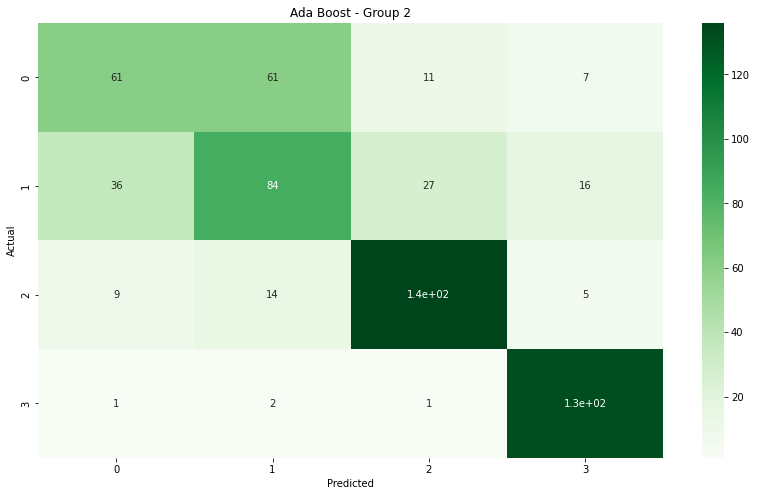

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7332644167426775; Accuracy score = 0.7466666666666667 ; Precisison Score = 0.7569963369963371; Recall score = 0.7466666666666667


 Aggregate report 
               precision    recall  f1-score   support

           0       0.83      0.48      0.61        21
           1       0.86      1.00      0.92        18
           2       0.69      0.90      0.78        20
           3       0.62      0.62      0.62        16

    accuracy                           0.75        75
   macro avg       0.75      0.75      0.73        75
weighted avg       0.76      0.75      0.73        75



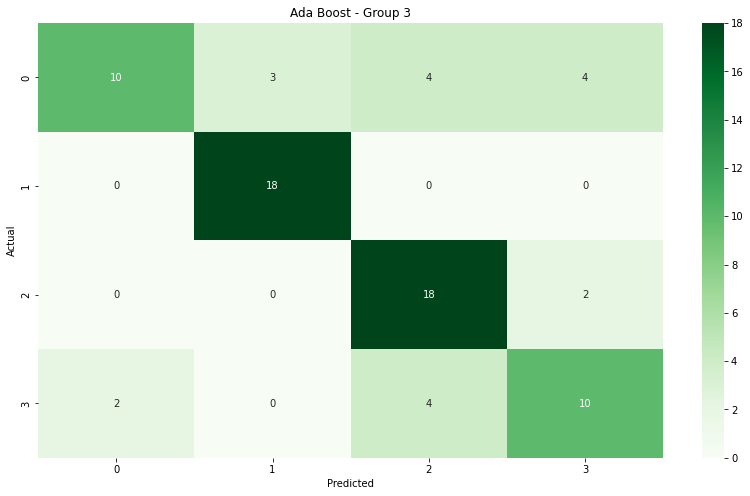

In [159]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual, predicted, X_test_list[i] = run_model(adtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.66      0.55      0.60        53
           1       0.59      0.37      0.45        52
           2       0.58      0.82      0.68        45
           3       0.74      0.90      0.81        48

    accuracy                           0.65       198
   macro avg       0.64      0.66      0.64       198
weighted avg       0.64      0.65      0.63       198



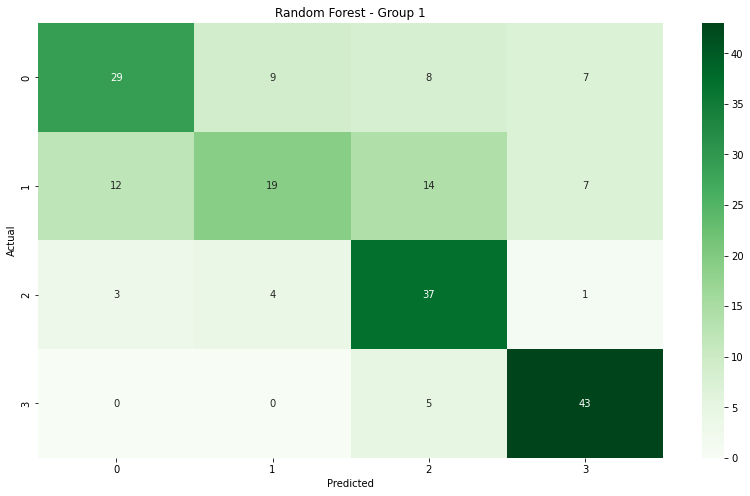



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.41      0.48        54
           1       0.40      0.41      0.40        51
           2       0.60      0.71      0.65        48
           3       0.69      0.78      0.73        49

    accuracy                           0.57       202
   macro avg       0.57      0.58      0.57       202
weighted avg       0.57      0.57      0.56       202



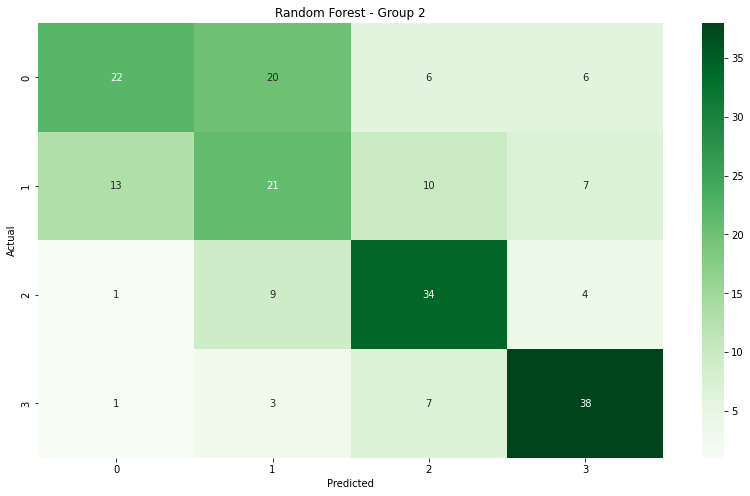



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.38      0.55        16
           1       0.50      0.83      0.62         6
           2       0.23      0.60      0.33         5
           3       0.64      0.56      0.60        16

    accuracy                           0.53        43
   macro avg       0.59      0.59      0.53        43
weighted avg       0.71      0.53      0.55        43



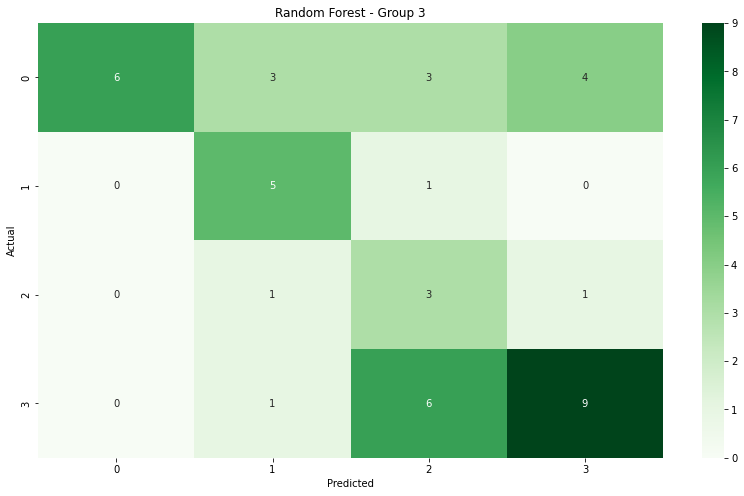

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt61,0,3
1,01avx2fm1t961,3,3
2,03mglec8fez51,1,2
3,0653ipqy7vd71,2,2
4,095x9borh0z61,2,2
...,...,...,...
193,xan1gwbxrwc61,0,2
194,xbw64yf04th51,1,3
195,xc76oggvh2471,1,2
196,xdz15thrnem51,2,2


In [160]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

adaboost with svm base

In [ ]:
quick_parameters = {
  'base_estimator' : [svm_final_model],
  'n_estimators' : [ 50, 100, 200],
  'learning_rate' : [ 0.001, 0.01, 0.1, 1],
  'algorithm' : ['SAMME']
}

astree = AdaBoostClassifier()
hyperparameter_tuning_random(astree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(astree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(astree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}


{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}

{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}

{'n_estimators': 100, 'learning_rate': 0.01, 'base_estimator': SVC(C=1000, gamma='auto'), 'algorithm': 'SAMME'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6532480700913699; Accuracy score = 0.6567164179104478 ; Precisison Score = 0.6507690612957756; Recall score = 0.6567164179104478


 Aggregate report 
               precision    recall  f1-score   support

           0       0.56      0.53      0.55       131
           1       0.53      0.49      0.51       148
           2       0.68      0.70      0.69       155
           3       0.81      0.86      0.83       169

    accuracy                           0.66       603
   macro avg       0.64      0.65      0.64       603
weighted avg       0.65      0.66      0.65       603



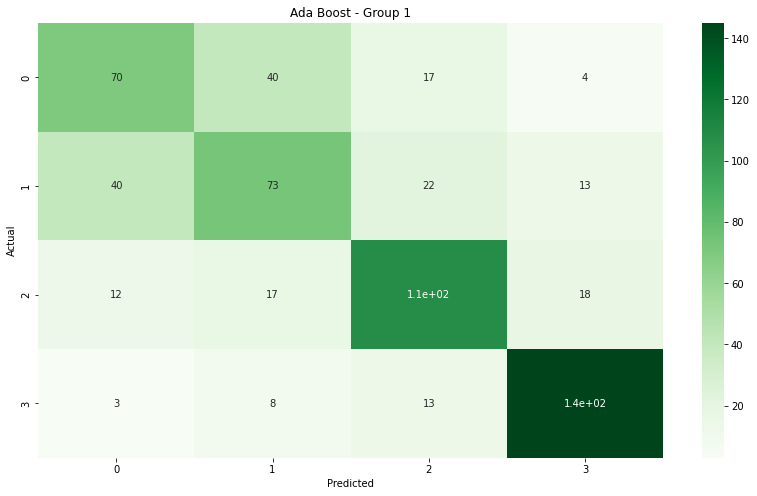

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5429095080448836; Accuracy score = 0.5456053067993366 ; Precisison Score = 0.5420476018446664; Recall score = 0.5456053067993366


 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.60      0.60       135
           1       0.46      0.40      0.42       159
           2       0.47      0.51      0.49       158
           3       0.65      0.70      0.67       151

    accuracy                           0.55       603
   macro avg       0.55      0.55      0.55       603
weighted avg       0.54      0.55      0.54       603



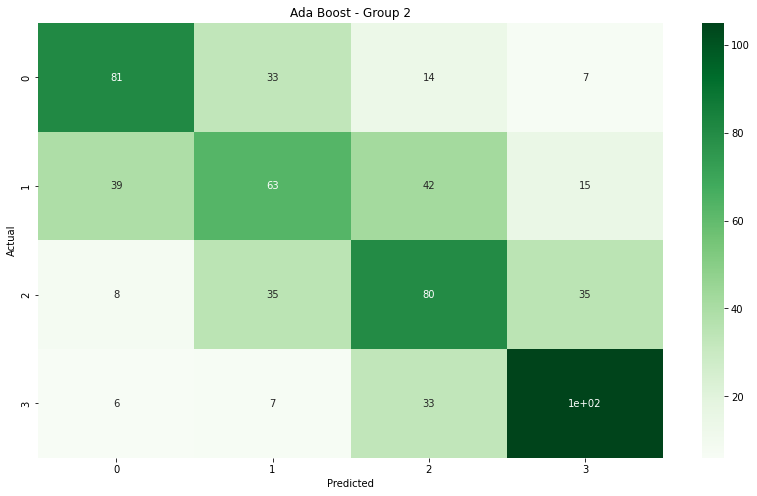

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7311770690494096; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7396122717861848; Recall score = 0.7333333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.75      0.65        16
           1       0.90      0.90      0.90        20
           2       0.78      0.75      0.77        24
           3       0.64      0.47      0.54        15

    accuracy                           0.73        75
   macro avg       0.72      0.72      0.71        75
weighted avg       0.74      0.73      0.73        75



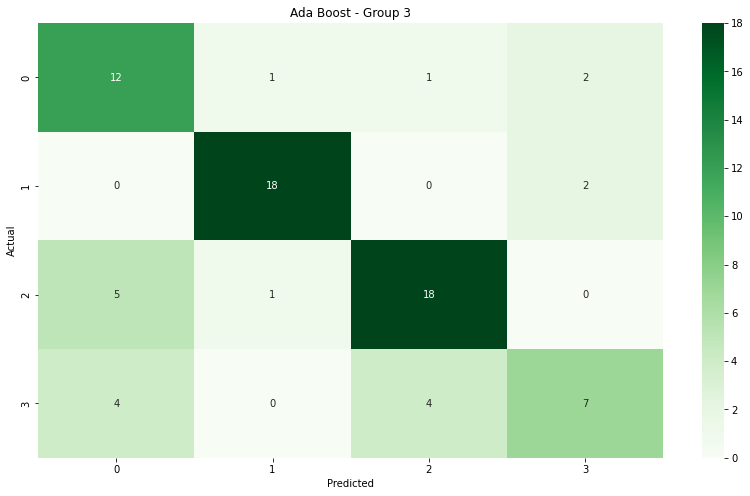

In [161]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]

for i in range(3):
    svm_train = copy.deepcopy(lst_df[i])
    svm_base = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree = 3)
    # Only train on this feature set
    feature_set = svm_train.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    svm_base.fit(svm_train[feature_set], lst_label_np[i])
    astree = AdaBoostClassifier(base_estimator = svm_base, n_estimators=100, learning_rate=0.01, algorithm ='SAMME')
    actual, predicted, X_test_list[i] = run_model(astree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.53      0.58        53
           1       0.51      0.47      0.49        47
           2       0.51      0.66      0.57        44
           3       0.75      0.75      0.75        53

    accuracy                           0.60       197
   macro avg       0.60      0.60      0.60       197
weighted avg       0.61      0.60      0.60       197



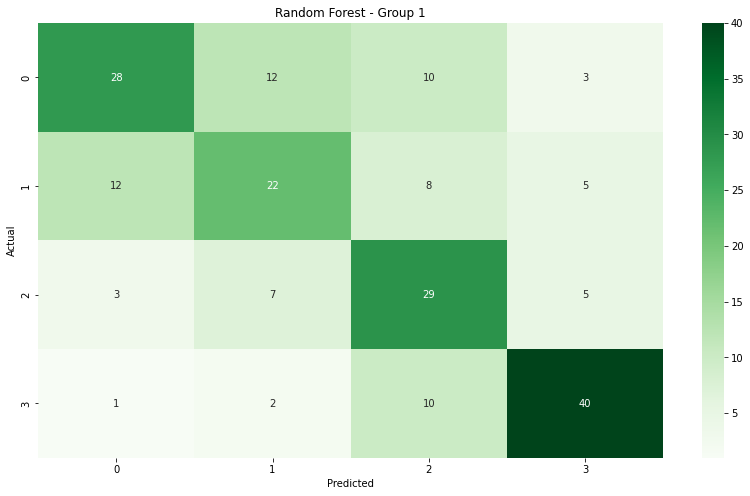



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.56      0.57        50
           1       0.38      0.30      0.33        47
           2       0.55      0.60      0.57        47
           3       0.56      0.64      0.60        45

    accuracy                           0.52       189
   macro avg       0.51      0.52      0.52       189
weighted avg       0.51      0.52      0.52       189



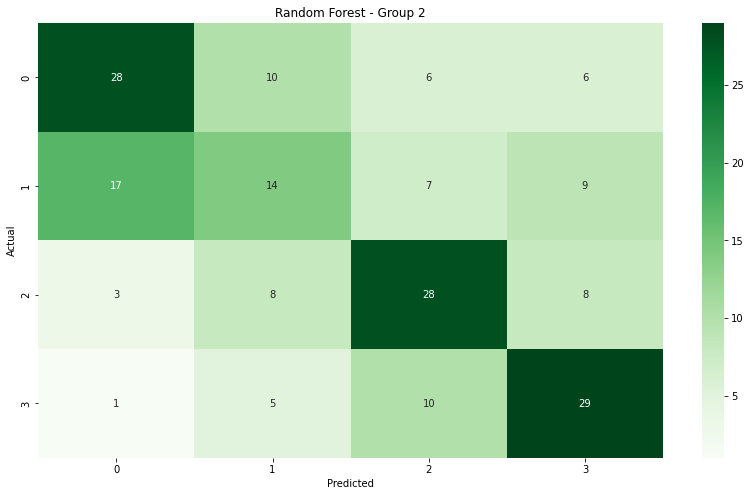



 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.83      0.83      0.83         6
           2       0.27      1.00      0.43         3
           3       0.75      0.43      0.55        14

    accuracy                           0.61        33
   macro avg       0.65      0.72      0.62        33
weighted avg       0.72      0.61      0.62        33



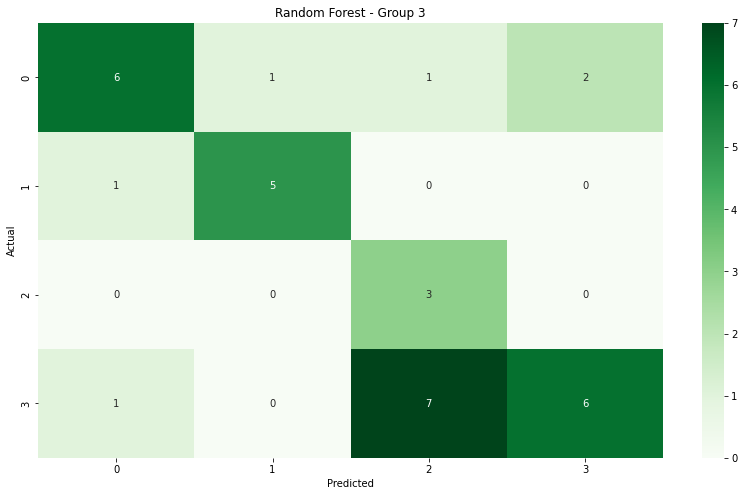

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,3
1,0202on89vhz61,0,0
2,03mglec8fez51,1,0
3,0653ipqy7vd71,2,3
4,065hfyuu0ya61,0,1
...,...,...,...
192,xbw64yf04th51,1,1
193,xc76oggvh2471,1,3
194,xda96lajcd871,0,0
195,xdz15thrnem51,2,3


In [162]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

this one is interesting because most of our models have close to 0.7 f1 score for all data and Non-noisy, this one performs worse, but, seems to outperform for noisy, we can consider this when weighting methods in the ensemble.

## XG Boost

In [ ]:
quick_parameters = {
  'min_child_weight': [1, 5, 10, 15],
  'gamma': [0.5, 1, 1.5, 2, 5],
  'subsample': [0.6, 0.8, 1.0],
  'colsample_bytree': [0.6, 0.8, 1.0],
  'max_depth': [2, 5, 10, 15],
  'alpha' : [0.1, 1, 3, 6],
  'lambda' :  [1, 3, 6],
  'max_delta_step' : [2],
  'objective' : ['reg:squarederror'],
  'eta' :  [ 0.01, 0.1, 1, 10],
  'num_boost_round' : [5]
}

xgtree = XGBClassifier()
hyperparameter_tuning_random(xgtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(xgtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(xgtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

XGBoostError: value 1.2 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

{'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 5, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 3, 'gamma': 1, 'eta': 1, 'colsample_bytree': 0.8, 'alpha': 0.1}


{'subsample': 0.8, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 2, 'lambda': 1, 'gamma': 1, 'eta': 0.1, 'colsample_bytree': 0.6, 'alpha': 0.1}


{'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 6, 'gamma': 0.5, 'eta': 0.1, 'colsample_bytree': 1.0, 'alpha': 1}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[12:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7013760928894103; Accuracy score = 0.7064676616915423 ; Precisison Score = 0.7037183139056147; Recall score = 0.7064676616915423


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.57      0.64       162
           1       0.56      0.55      0.56       145
           2       0.69      0.77      0.73       159
           3       0.84      0.95      0.89       137

    accuracy                           0.71       603
   macro avg       0.71      0.71      0.71       603
weighted avg       0.70      0.71      0.70       603



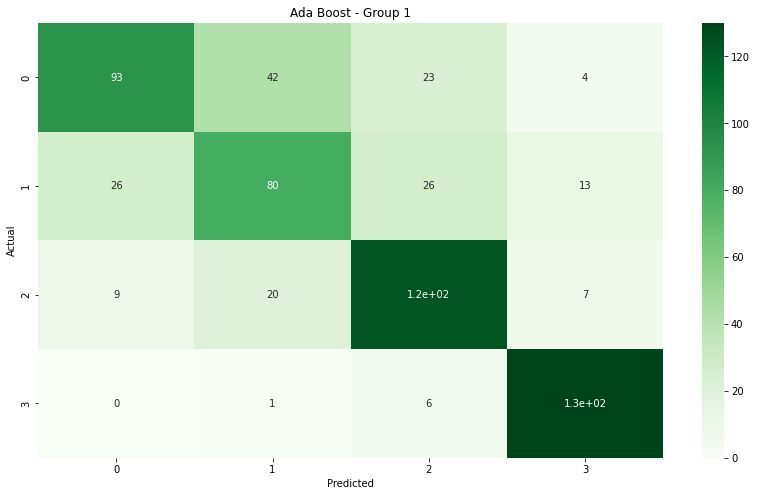

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[12:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:31:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7370300638667739; Accuracy score = 0.7429519071310116 ; Precisison Score = 0.7359675360963147; Recall score = 0.7429519071310116


 Aggregate report 
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       160
           1       0.63      0.59      0.61       164
           2       0.77      0.84      0.80       134
           3       0.85      0.97      0.91       145

    accuracy                           0.74       603
   macro avg       0.74      0.75      0.74       603
weighted avg       0.74      0.74      0.74       603



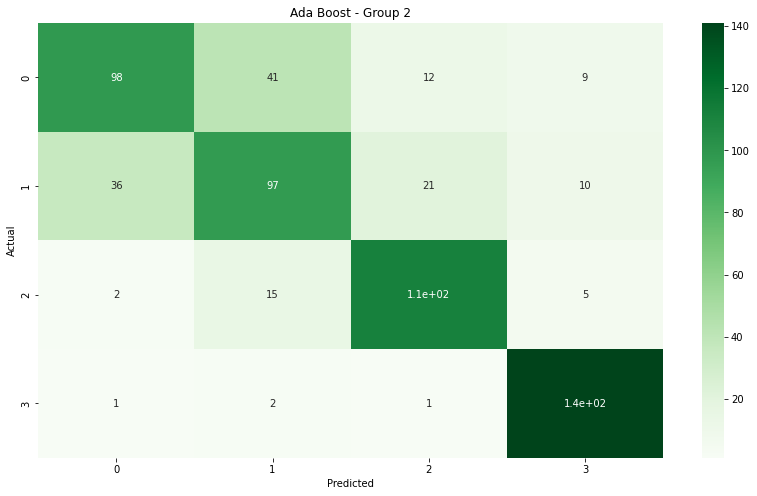

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[12:31:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:31:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7302272795226319; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7426269005847953; Recall score = 0.7333333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.84      1.00      0.91        21
           2       0.63      0.60      0.62        20
           3       0.58      0.65      0.61        17

    accuracy                           0.73        75
   macro avg       0.74      0.72      0.72        75
weighted avg       0.74      0.73      0.73        75



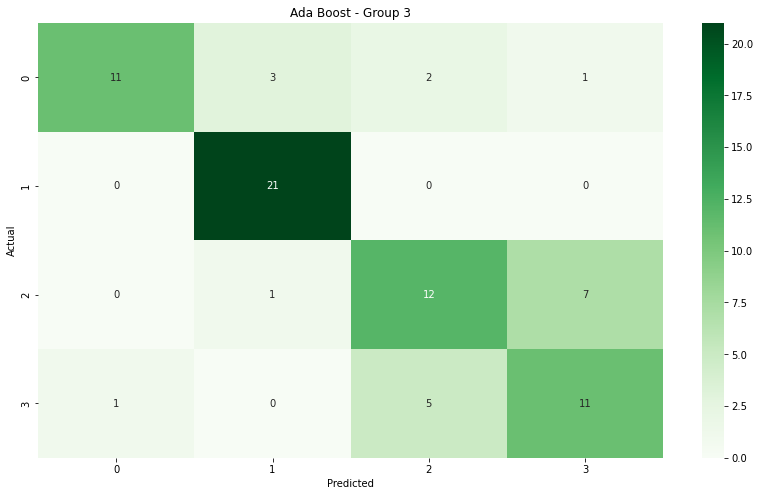

In [ ]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_df = copy.deepcopy(lst_df[i])

    for col in temp_xg_df:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_df[col] = temp_xg_df[col].astype(str).astype(float)

    actual, predicted, X_test_list[i] = run_model(xgtree, temp_xg_df, lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.71      0.64      0.67        55
           1       0.56      0.48      0.52        48
           2       0.58      0.72      0.64        50
           3       0.77      0.78      0.77        46

    accuracy                           0.65       199
   macro avg       0.66      0.65      0.65       199
weighted avg       0.66      0.65      0.65       199



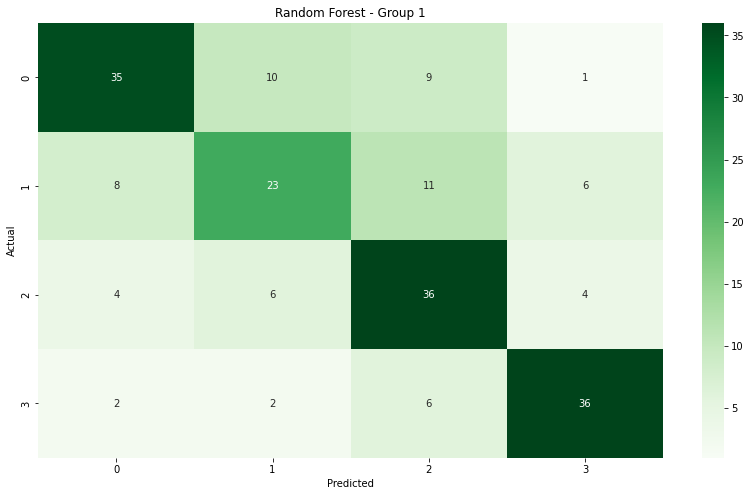



 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.49      0.55        61
           1       0.43      0.48      0.46        48
           2       0.59      0.67      0.62        45
           3       0.73      0.74      0.73        50

    accuracy                           0.59       204
   macro avg       0.59      0.59      0.59       204
weighted avg       0.59      0.59      0.59       204



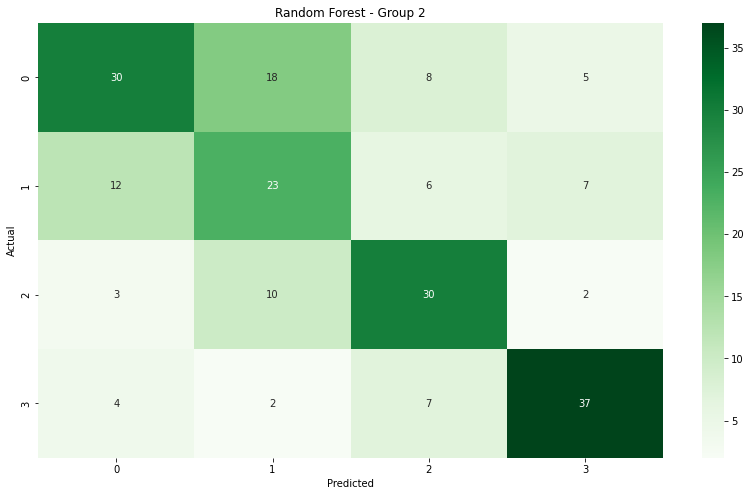



 Aggregate report 
               precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.36      0.80      0.50         5
           2       0.38      0.50      0.43         6
           3       0.89      0.62      0.73        13

    accuracy                           0.61        38
   macro avg       0.61      0.62      0.58        38
weighted avg       0.71      0.61      0.63        38



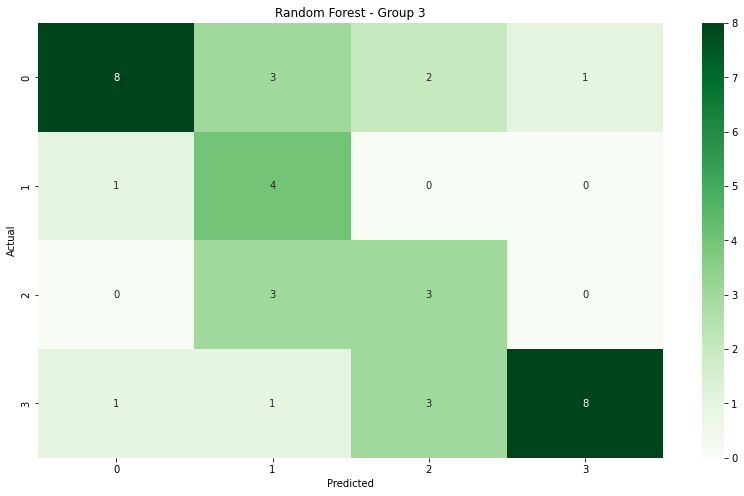

,parent_file_train,parent_label_train,segment_predictions
0,01avx2fm1t961,3,3
1,03mglec8fez51,1,2
2,0653ipqy7vd71,2,2
3,08ss0a3zs0061,2,2
4,095x9borh0z61,2,2
...,...,...,...
194,xan1gwbxrwc61,0,2
195,xc76oggvh2471,1,3
196,xda96lajcd871,0,0
197,xdz15thrnem51,2,2


In [ ]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

## Gradient Boosting

In [ ]:
quick_parameters = {
  'loss' : ["deviance"],
  'learning_rate' : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
  'min_samples_split' : np.linspace(0.01, 0.5, 14),
  'min_samples_leaf' : np.linspace(0.001, 0.5, 18),
  'max_depth' : [1,2,3,5,8],
  'max_features' : ["log2","sqrt"],
  'criterion' : ["friedman_mse",  "absolute_error"],
  'subsample' : [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
  'n_estimators' : [10, 20, 30, 50]
}

gbtree = GradientBoostingClassifier()
hyperparameter_tuning_random(gbtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(gbtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(gbtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'subsample': 1.0, 'n_estimators': 20, 'min_samples_split': 0.047692307692307694, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}
{'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.001, 'max_features': 'log2', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.025, 'criterion': 'friedman_mse'}
{'subsample': 0.95, 'n_estimators': 20, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}


{'subsample': 1.0, 'n_estimators': 20, 'min_samples_split': 0.047692307692307694, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}

{'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.001, 'max_features': 'log2', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.025, 'criterion': 'friedman_mse'}

{'subsample': 0.95, 'n_estimators': 20, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6372557729115595; Accuracy score = 0.6417910447761194 ; Precisison Score = 0.6355353178575998; Recall score = 0.6417910447761194


 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.51      0.55       140
           1       0.50      0.48      0.49       154
           2       0.66      0.70      0.68       147
           3       0.78      0.85      0.81       162

    accuracy                           0.64       603
   macro avg       0.63      0.64      0.63       603
weighted avg       0.64      0.64      0.64       603



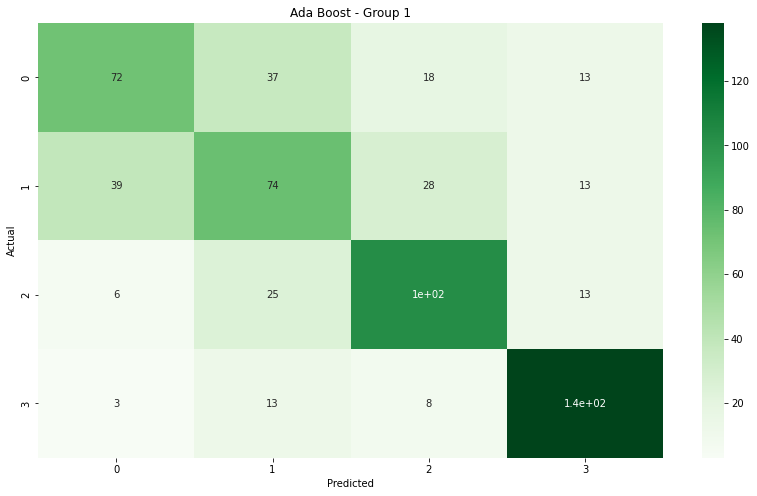

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.65559571048416; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.6535926625989249; Recall score = 0.6666666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.55      0.58       138
           1       0.56      0.46      0.51       162
           2       0.68      0.70      0.69       150
           3       0.77      0.96      0.85       153

    accuracy                           0.67       603
   macro avg       0.65      0.67      0.66       603
weighted avg       0.65      0.67      0.66       603



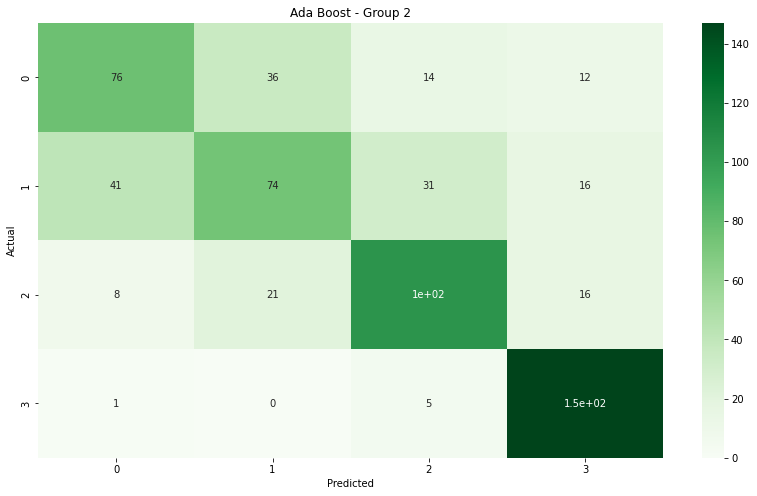

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8115315315315315; Accuracy score = 0.8133333333333334 ; Precisison Score = 0.8230555555555555; Recall score = 0.8133333333333334


 Aggregate report 
               precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       1.00      1.00      1.00        20
           2       0.67      0.88      0.76        16
           3       0.78      0.78      0.78        18

    accuracy                           0.81        75
   macro avg       0.81      0.82      0.81        75
weighted avg       0.82      0.81      0.81        75



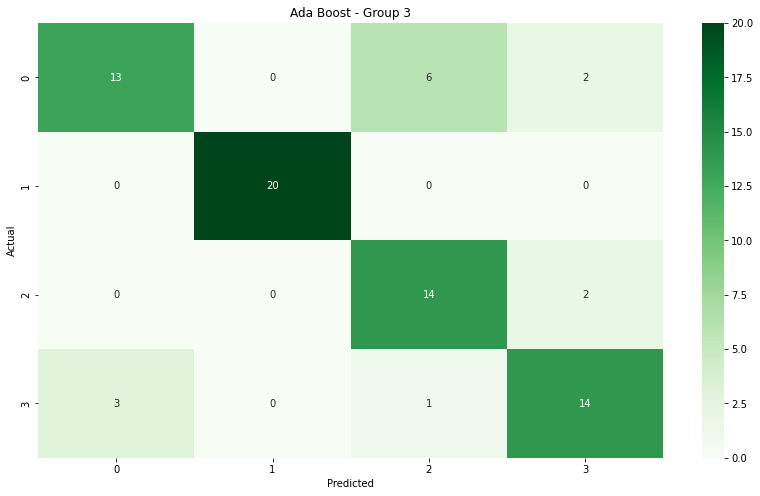

In [163]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual, predicted, X_test_list[i] = run_model(gbtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1}", actual, predicted, ['0', '1', '2', '3'])



 Aggregate report 
               precision    recall  f1-score   support

           0       0.56      0.45      0.50        53
           1       0.43      0.33      0.38        48
           2       0.56      0.70      0.62        46
           3       0.66      0.78      0.71        51

    accuracy                           0.57       198
   macro avg       0.55      0.57      0.55       198
weighted avg       0.55      0.57      0.55       198



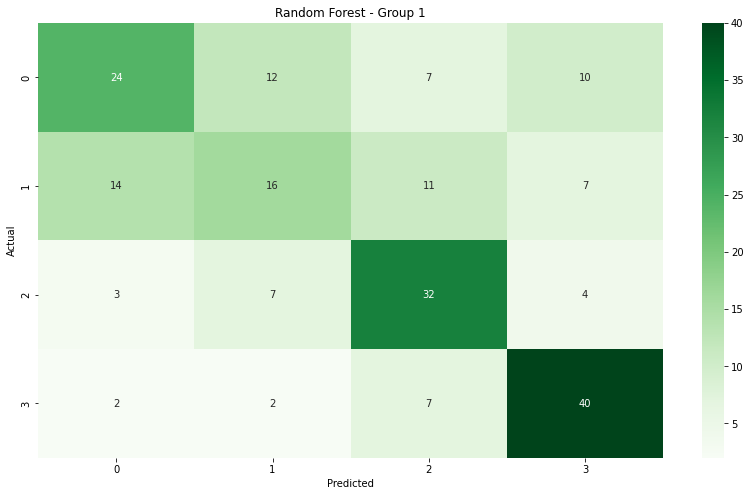



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.56      0.59        54
           1       0.60      0.45      0.52        55
           2       0.56      0.64      0.59        47
           3       0.63      0.81      0.71        47

    accuracy                           0.61       203
   macro avg       0.61      0.61      0.60       203
weighted avg       0.61      0.61      0.60       203



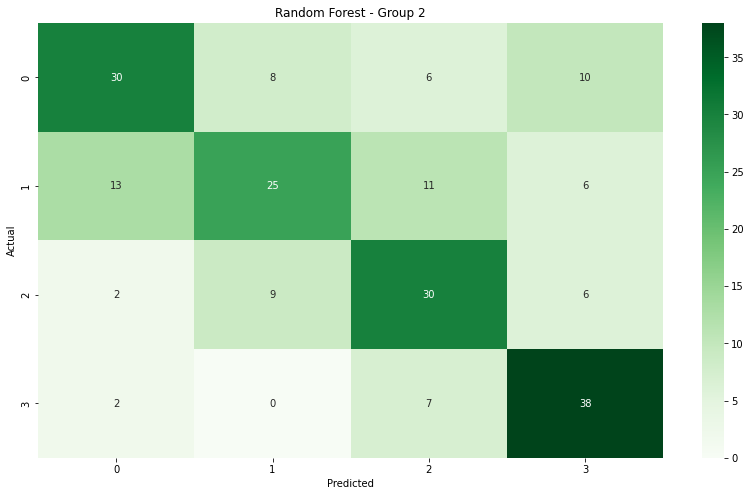



 Aggregate report 
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.83      0.83      0.83         6
           2       0.33      0.75      0.46         4
           3       0.83      0.62      0.71        16

    accuracy                           0.70        37
   macro avg       0.70      0.73      0.69        37
weighted avg       0.77      0.70      0.72        37



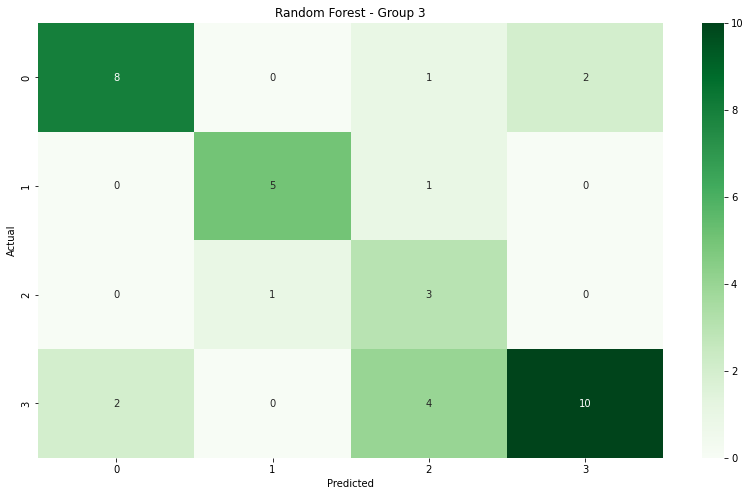

,parent_file_train,parent_label_train,segment_predictions
0,00g8dfgpqpt61,0,3
1,01avx2fm1t961,3,3
2,0202on89vhz61,0,1
3,03mglec8fez51,1,1
4,0653ipqy7vd71,2,3
...,...,...,...
193,xan1gwbxrwc61,0,3
194,xc76oggvh2471,1,3
195,xda96lajcd871,0,0
196,xdz15thrnem51,2,2


In [164]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1}", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

max_parent_df_list[0]

## Plot the current results

In [ ]:
import matplotlib.pyplot as plt

For segments

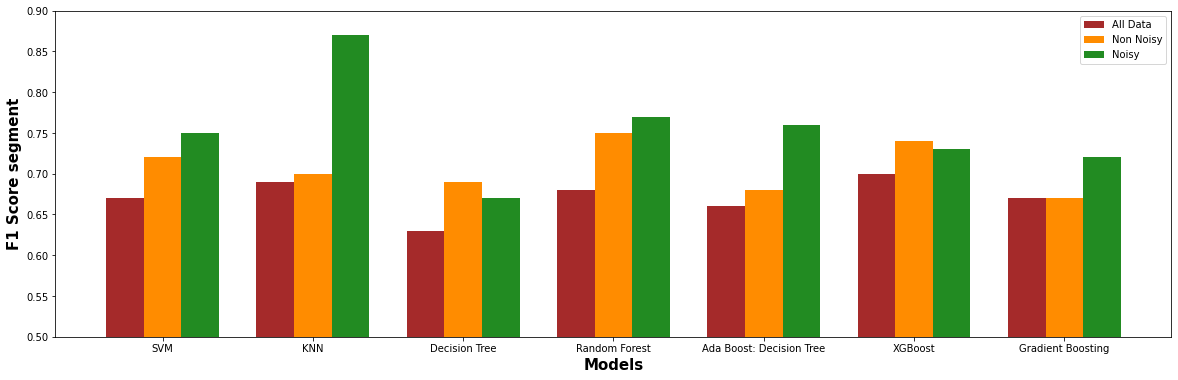

In [87]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.69, 0.63, 0.68, 0.66, 0.70, 0.67 ]
f1_non_noisy = [0.72, 0.70, 0.69, 0.75, 0.68, 0.74, 0.67]
f1_noisy = [0.75, 0.87, 0.67, 0.77, 0.76, 0.73, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.9])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

for parent

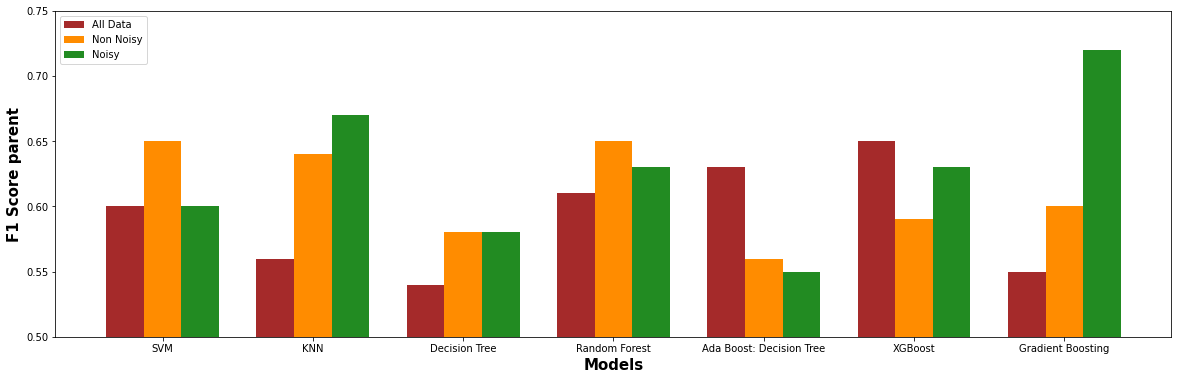

In [83]:
#f1 scores entered manually to control for randomization
f1_all = [0.60, 0.56, 0.54, 0.61, 0.63, 0.65, 0.55]
f1_non_noisy = [0.65, 0.64, 0.58, 0.65, 0.56, 0.59, 0.60]
f1_noisy = [0.60, 0.67, 0.58, 0.63, 0.55, 0.63, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.75])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

## Ensemble all methods

Do one test/train split for all models, no need for validation as we have set the hyper parameters then train each of the models on this same training set

In [36]:
def run_model_pre_split(ml_model, X_train, X_test, y_train, y_test):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = X_train.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

In [37]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(standardized_aggression_df_balanced, label_balanced_np, test_size=0.25)

In [38]:
X_train_non_noisy, X_test_non_noisy, y_train_non_noisy, y_test_non_noisy = train_test_split(standardized_non_noisy_df_balanced, label_balanced_non_noisy_np, test_size=0.25)

In [39]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(standardized_noisy_df_balanced, label_balanced_noisy_np, test_size=0.25)

### SVM

Segment

In [40]:
label = 'segment_label_train'
X_test_list_svm = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]
predicted_svm = [None, None, None]
actual_svm = [None, None, None]
X_train = [X_train_all, X_train_non_noisy, X_train_noisy]
X_test = [X_test_all, X_test_non_noisy, X_test_noisy]
y_train = [y_train_all, y_train_non_noisy, y_train_noisy]
y_test = [y_test_all, y_test_non_noisy, y_test_noisy]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual_svm[i], predicted_svm[i], X_test_list_svm[i] = run_model_pre_split(svm_model, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6739535475169028; Accuracy score = 0.6782752902155887 ; Precisison Score = 0.6724427838346474; Recall score = 0.6782752902155887
F1 score = 0.718041135416408; Accuracy score = 0.7262103505843072 ; Precisison Score = 0.7139485783183612; Recall score = 0.7262103505843072
F1 score = 0.7715641299584811; Accuracy score = 0.7866666666666666 ; Precisison Score = 0.8020444444444444; Recall score = 0.7866666666666666


Parent

In [41]:
max_parent_df_list_svm = [None, None, None]

for i in range(0,len(X_test_list_svm)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_svm[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_svm[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_svm[i]['segment_predictions'], max_parent_df_list_svm[i]['parent_label_train'], average='weighted')}")

F1 score = 0.5824612961498313
F1 score = 0.6348527540048278
F1 score = 0.5793114208446016


### KNN

Segment

In [47]:
X_test_list_knn = [None,None,None]
predicted_knn = [None, None, None]
actual_knn = [None, None, None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual_knn[i], predicted_knn[i], X_test_list_knn[i] = run_model_pre_split(knn, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6952604313279107; Accuracy score = 0.7014925373134329 ; Precisison Score = 0.6949090872051944; Recall score = 0.7014925373134329
F1 score = 0.7124861967028228; Accuracy score = 0.7212020033388982 ; Precisison Score = 0.7137191568659356; Recall score = 0.7212020033388982
F1 score = 0.8262242703533027; Accuracy score = 0.8266666666666667 ; Precisison Score = 0.8529977116704806; Recall score = 0.8266666666666667


Parent

In [48]:
max_parent_df_list_knn = [None, None, None]

for i in range(0,len(X_test_list_knn)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_knn[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_knn[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_knn[i]['parent_label_train'], max_parent_df_list_knn[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6223001590203264
F1 score = 0.5600601085661328
F1 score = 0.6906342780026989


### Decision Tree

Segment

In [49]:
X_test_list_dt = [None,None,None]
predicted_dt = [None, None, None]
actual_dt = [None, None, None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual_dt[i], predicted_dt[i], X_test_list_dt[i] = run_model_pre_split(dtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6708183656870286; Accuracy score = 0.6782752902155887 ; Precisison Score = 0.6667789175630754; Recall score = 0.6782752902155887
F1 score = 0.6969495259423805; Accuracy score = 0.7078464106844741 ; Precisison Score = 0.6938990911009528; Recall score = 0.7078464106844741
F1 score = 0.7482360471070147; Accuracy score = 0.76 ; Precisison Score = 0.7544659977703456; Recall score = 0.76


Parent

In [50]:
max_parent_df_list_dt = [None, None, None]

for i in range(0,len(X_test_list_dt)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_dt[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_dt[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_dt[i]['parent_label_train'], max_parent_df_list_dt[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6240980693021243
F1 score = 0.5837928220110046
F1 score = 0.5560912771439087


### Random Forest

Segment

In [51]:
X_test_list_rf = [None,None,None]
predicted_rf = [None, None, None]
actual_rf = [None, None, None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual_rf[i], predicted_rf[i], X_test_list_rf[i] = run_model_pre_split(rtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.7268735010292626; Accuracy score = 0.7280265339966833 ; Precisison Score = 0.7267489645523788; Recall score = 0.7280265339966833
F1 score = 0.7476927715844005; Accuracy score = 0.7545909849749582 ; Precisison Score = 0.7463279672562199; Recall score = 0.7545909849749582
F1 score = 0.8238705996845531; Accuracy score = 0.8266666666666667 ; Precisison Score = 0.8347110860154339; Recall score = 0.8266666666666667


Parent

In [52]:
max_parent_df_list_rf = [None, None, None]

for i in range(0,len(X_test_list_rf)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_rf[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_rf[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_rf[i]['parent_label_train'], max_parent_df_list_rf[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6630163380769564
F1 score = 0.5919681225199995
F1 score = 0.6888433204222678


### Ada Boost with Decision tree base

Segment

In [53]:
X_test_list_ad = [None,None,None]
predicted_ad = [None, None, None]
actual_ad = [None, None, None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual_ad[i], predicted_ad[i], X_test_list_ad[i] = run_model_pre_split(adtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.680182765930275; Accuracy score = 0.6799336650082919 ; Precisison Score = 0.6860680252132827; Recall score = 0.6799336650082919
F1 score = 0.7158185385326158; Accuracy score = 0.7228714524207012 ; Precisison Score = 0.7131238119390507; Recall score = 0.7228714524207012
F1 score = 0.6963507263370464; Accuracy score = 0.72 ; Precisison Score = 0.7188888888888889; Recall score = 0.72


Parent

In [54]:
max_parent_df_list_ad = [None, None, None]

for i in range(0,len(X_test_list_ad)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_ad[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_ad[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_ad[i]['parent_label_train'], max_parent_df_list_ad[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6198427931926478
F1 score = 0.5787428172734296
F1 score = 0.5126605511158224


### XGBoost

Segment

In [55]:
X_test_list_xg = [None,None,None]
predicted_xg = [None, None, None]
actual_xg = [None, None, None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_train = copy.deepcopy(X_train[i])

    for col in temp_xg_train:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_train[col] = temp_xg_train[col].astype(str).astype(float)

    temp_xg_test = copy.deepcopy(X_test[i])

    for col in temp_xg_test:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_test[col] = temp_xg_test[col].astype(str).astype(float)

    actual_xg[i], predicted_xg[i], X_test_list_xg[i] = run_model_pre_split(xgtree, temp_xg_train, temp_xg_test, y_train[i], y_test[i])

c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:37:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:37:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score = 0.6818631345601955; Accuracy score = 0.6849087893864013 ; Precisison Score = 0.6803789518748479; Recall score = 0.6849087893864013
[09:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_bo

c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7305283604913422; Accuracy score = 0.7362270450751253 ; Precisison Score = 0.7278161136234598; Recall score = 0.7362270450751253
[09:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Paige\Documents\CMPT724\final_project\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7402414510554045; Accuracy score = 0.7466666666666667 ; Precisison Score = 0.7496048026994319; Recall score = 0.7466666666666667


Parent

In [56]:
max_parent_df_list_xg = [None, None, None]

for i in range(0,len(X_test_list_xg)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_xg[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_xg[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_xg[i]['parent_label_train'], max_parent_df_list_xg[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6610004370511163
F1 score = 0.5991998191681736
F1 score = 0.6113360323886641


### Gradient Boosting

Segment

In [57]:
X_test_list_gb = [None,None,None]
predicted_gb = [None, None, None]
actual_gb = [None, None, None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbtree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual_gb[i], predicted_gb[i], X_test_list_gb[i] = run_model_pre_split(gbtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.564559502398808; Accuracy score = 0.5688225538971807 ; Precisison Score = 0.5699527993758365; Recall score = 0.5688225538971807
F1 score = 0.5773655108312358; Accuracy score = 0.5826377295492488 ; Precisison Score = 0.5867760345438054; Recall score = 0.5826377295492488
F1 score = 0.6914708994708995; Accuracy score = 0.6933333333333334 ; Precisison Score = 0.7191567852437418; Recall score = 0.6933333333333334


Parent

In [58]:
max_parent_df_list_gb = [None, None, None]

for i in range(0,len(X_test_list_gb)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_gb[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_gb[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_gb[i]['parent_label_train'], max_parent_df_list_gb[i]['segment_predictions'], average='weighted')}")

F1 score = 0.5316024690132697
F1 score = 0.4586352693731312
F1 score = 0.59626338573707


## Ensemble

All data

In [59]:
predicted_all = [predicted_svm[0],predicted_knn[0], predicted_dt[0], predicted_rf[0], predicted_ad[0], predicted_xg[0], predicted_gb[0]]

Equally balanced models, i.e. max vote

In [60]:
label = [0] * len(predicted_all[0])

for i in range(len(predicted_all[0])):
  for model in predicted_all:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [61]:
final_all_label = [round(x) for x in label]

get f1 score

In [62]:
fone_score = f1_score(y_test_all, final_all_label, average='weighted')
print(fone_score)

0.6930639322778155


get parent labels

In [66]:
X_test_list_gb[0]["ensemble"] = final_all_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[0]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[0] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[0]['parent_label_train'], max_parent_df_list_gb[0]['ensemble'], average='weighted')}")

F1 score = 0.6420917770896061


Non Noisy data

In [67]:
predicted_non_noisy = [predicted_svm[1],predicted_knn[1], predicted_dt[1], predicted_rf[1], predicted_ad[1], predicted_xg[1], predicted_gb[1]]

Equally balanced models, i.e. max vote

In [68]:
label = [0] * len(predicted_non_noisy[0])

for i in range(len(predicted_non_noisy[0])):
  for model in predicted_non_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [69]:
final_non_noisy_label = [round(x) for x in label]

get f1 score

In [70]:
fone_score = f1_score(y_test_non_noisy, final_non_noisy_label, average='weighted')
print(fone_score)

0.7583342758090176


get parent labels

In [72]:
X_test_list_gb[1]["ensemble"] = final_non_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[1]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[1] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[1]['parent_label_train'], max_parent_df_list_gb[1]['ensemble'], average='weighted')}")

F1 score = 0.6056355048842149


Noisy data

In [73]:
predicted_noisy = [predicted_svm[2],predicted_knn[2], predicted_dt[2], predicted_rf[2], predicted_ad[2], predicted_xg[2], predicted_gb[2]]

Equally balanced models, i.e. max vote

In [74]:
label = [0] * len(predicted_noisy[0])

for i in range(len(predicted_noisy[0])):
  for model in predicted_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [75]:
final_noisy_label = [round(x) for x in label]

get f1 score

In [76]:
fone_score = f1_score(y_test_noisy, final_noisy_label, average='weighted')
print(fone_score)

0.6883866857779901


get parent labels

In [77]:
X_test_list_gb[2]["ensemble"] = final_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[2]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[2] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[2]['parent_label_train'], max_parent_df_list_gb[2]['ensemble'], average='weighted')}")

F1 score = 0.5114608044174608


# Visualize final models with the same test set

Segment

Hard code to avoid randomization of splits

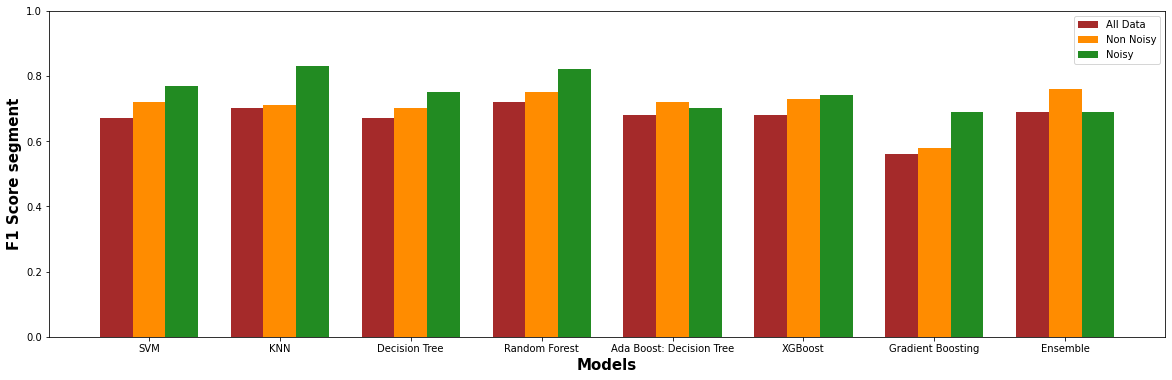

In [80]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.70, 0.67, 0.72, 0.68, 0.68, 0.56, 0.69]
f1_non_noisy = [0.72, 0.71, 0.70, 0.75, 0.72, 0.73, 0.58, 0.76]
f1_noisy = [0.77, 0.83, 0.75, 0.82, 0.70, 0.74, 0.69, 0.69]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()

Parent

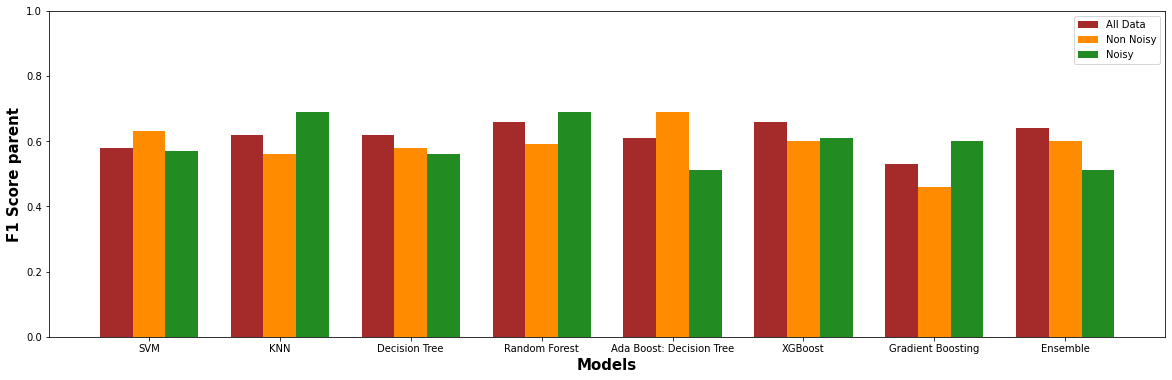

In [82]:
#f1 scores entered manually to control for randomization
f1_all = [0.58, 0.62, 0.62, 0.66, 0.61, 0.66, 0.53, 0.64]
f1_non_noisy = [0.63, 0.56, 0.58, 0.59, 0.69, 0.60, 0.46, 0.60]
f1_noisy = [0.57, 0.69, 0.56, 0.69, 0.51, 0.61, 0.60, 0.51]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()